# Bank Marketing Campaign Analysis

Marketing campaigns are extremely important for a company's success. But, they are often difficult to track and understand what is actually effective. Are we targeting the right people? Are we contacting them in the right way? We might want to take a look at different engagement metrics. Who interacted with the campaign the most? This could look like clicks or likes on ads on the user's phone.

This marketing campaign analysis will take a look at conversion success for a bank. Specifically, it will analyze and predict which customers are more likely to deposit money after a marketing campaign was done.

## Loading in Data

In [1]:
# Load in necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from six import StringIO
from IPython.display import Image
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy import stats
import plotly.express as px

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load in Dataset
file_path = '/content/bank.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
df.head()


age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no   2343.0     yes   no  unknown   
1   56      admin.  married  secondary      no     45.0      no   no  unknown   
2   41  technician  married  secondary      no   1270.0     yes   no  unknown   
3   55    services  married  secondary      no   2476.0     yes   no  unknown   
4   54      admin.  married   tertiary      no    184.0      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0  5.0   may    1042.0       1.0   -1.0       0.0  unknown     yes  
1  5.0   may    1467.0       1.0   -1.0       0.0  unknown     yes  
2  5.0   may    1389.0       1.0   -1.0       0.0  unknown     yes  
3  5.0   may     579.0       1.0   -1.0       0.0  unknown     yes  
4  5.0   may     673.0       2.0   -1.0       0.0  unknown     yes

## Data Cleaning

In [4]:
# Shape of data
df.shape

(11170, 17)

In [5]:
# Get basic info on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11170 entries, 0 to 11169
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11170 non-null  int64  
 1   job        11168 non-null  object 
 2   marital    11169 non-null  object 
 3   education  11169 non-null  object 
 4   default    11170 non-null  object 
 5   balance    11168 non-null  float64
 6   housing    11170 non-null  object 
 7   loan       11169 non-null  object 
 8   contact    11170 non-null  object 
 9   day        11169 non-null  float64
 10  month      11170 non-null  object 
 11  duration   11169 non-null  float64
 12  campaign   11169 non-null  float64
 13  pdays      11169 non-null  float64
 14  previous   11169 non-null  float64
 15  poutcome   11170 non-null  object 
 16  deposit    11170 non-null  object 
dtypes: float64(6), int64(1), object(10)
memory usage: 1.4+ MB


In [6]:
# Check for missing values
df.isna().sum()

age          0
job          2
marital      1
education    1
default      0
balance      2
housing      0
loan         1
contact      0
day          1
month        0
duration     1
campaign     1
pdays        1
previous     1
poutcome     0
deposit      0
dtype: int64

In [7]:
# Remove rows with missing values
df = df.dropna()
# Check that it worked
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [8]:
# Check for duplicates
df.duplicated().sum()

5

In [9]:
# Drop duplicates
df = df.drop_duplicates()
# Check that it worked
df.duplicated().sum()

0

## EDA

Before we create any models based around the data, it's important to explore the data. Not just to see what each field represents, but also to take a look at descriptive analytics and to see if there is anything we can take away from the data before doing more manipulation.

In [10]:
# Shape of data
df.shape

(11162, 17)

In [11]:
# Summary statistics for numerical columns
round(df.describe(),2)

age   balance       day  duration  campaign     pdays  previous
count  11162.00  11162.00  11162.00  11162.00  11162.00  11162.00  11162.00
mean      41.23   1528.54     15.66    371.99      2.51     51.33      0.83
std       11.91   3225.41      8.42    347.13      2.72    108.76      2.29
min       18.00  -6847.00      1.00      2.00      1.00     -1.00      0.00
25%       32.00    122.00      8.00    138.00      1.00     -1.00      0.00
50%       39.00    550.00     15.00    255.00      2.00     -1.00      0.00
75%       49.00   1708.00     22.00    496.00      3.00     20.75      1.00
max       95.00  81204.00     31.00   3881.00     63.00    854.00     58.00

In [12]:
# Summary statistics for categorical columns
df.describe(include=['O'])

job  marital  education default housing   loan   contact  \
count        11162    11162      11162   11162   11162  11162     11162   
unique          12        3          4       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2566     6351       5476   10994    5881   9702      8042   

        month poutcome deposit  
count   11162    11162   11162  
unique     12        4       2  
top       may  unknown      no  
freq     2824     8326    5873

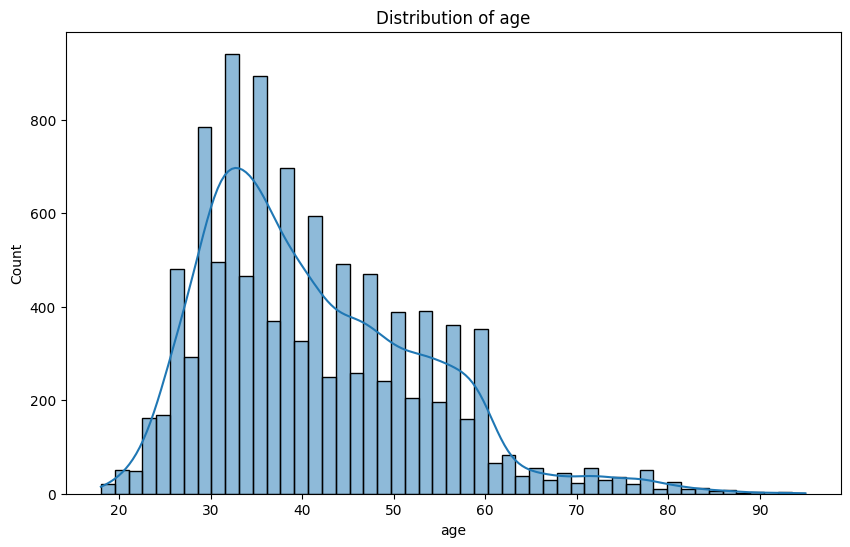

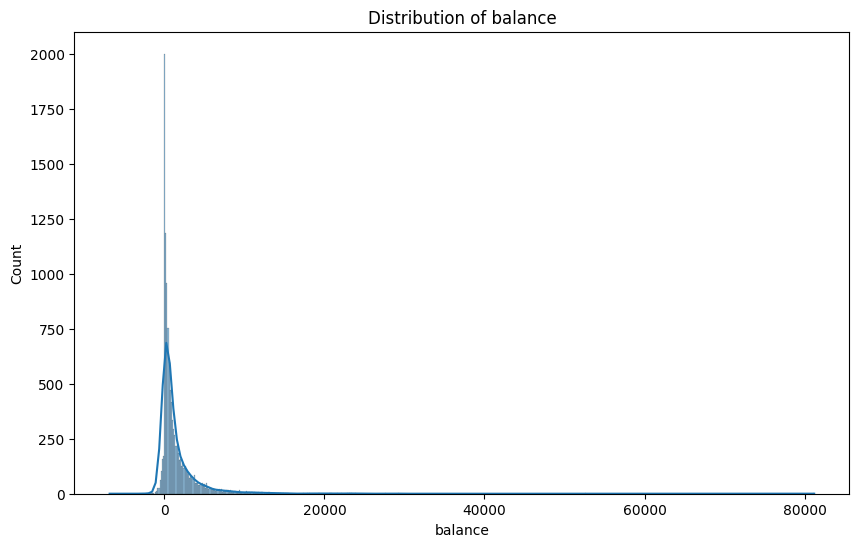

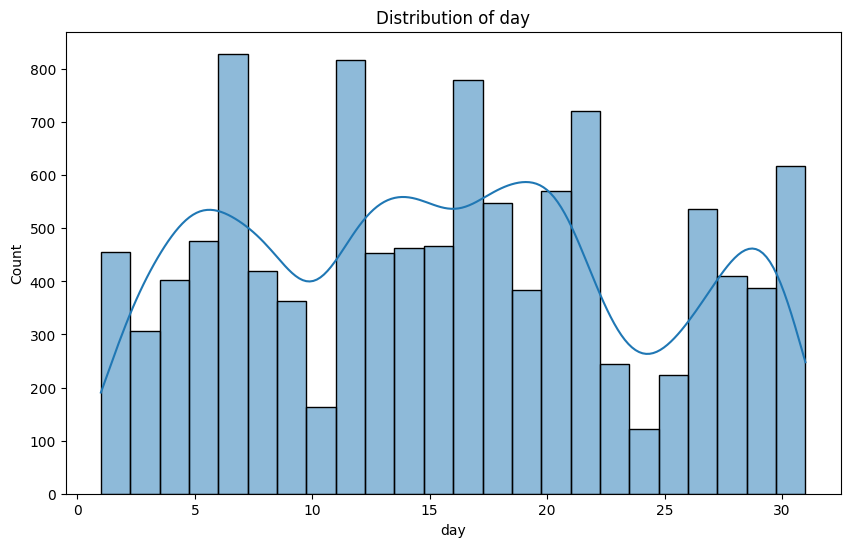

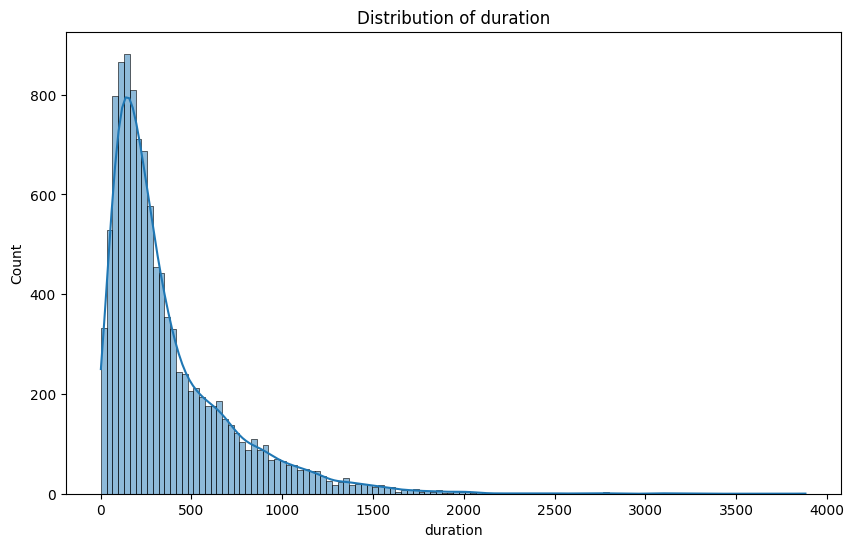

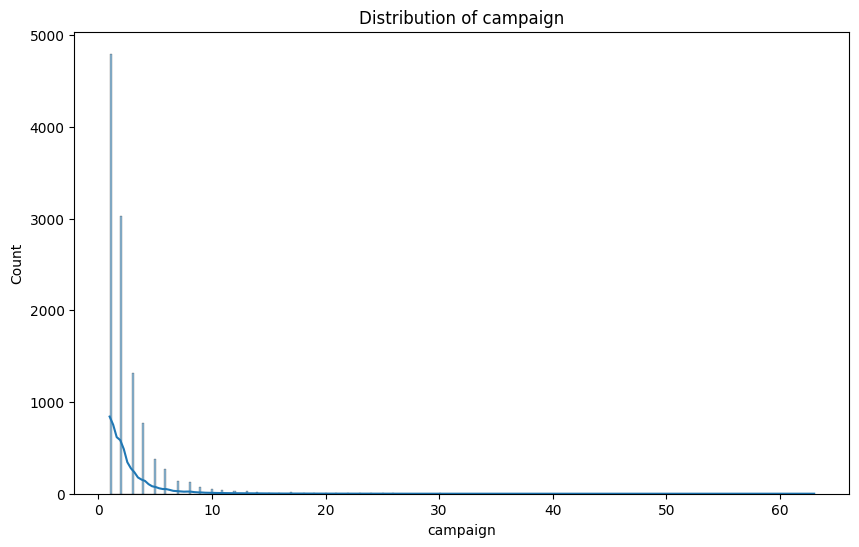

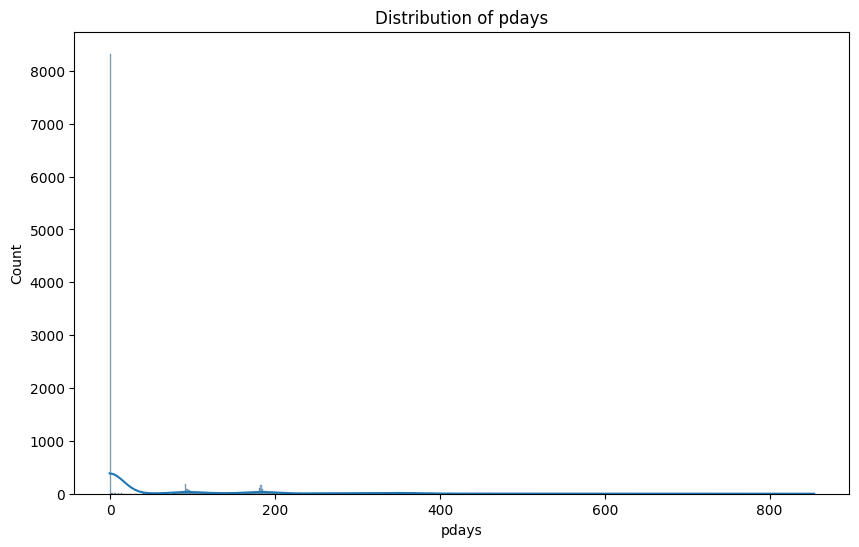

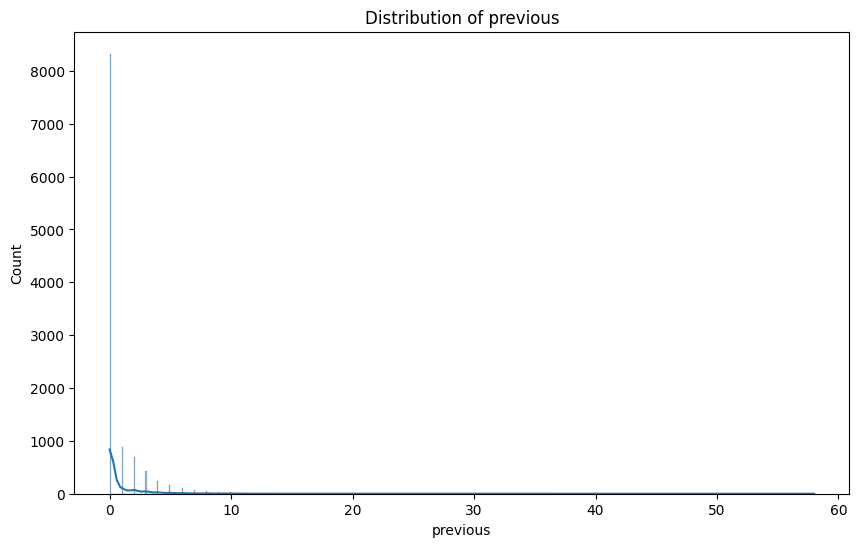

In [13]:
# Distribution plots for numerical variables
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
for column in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

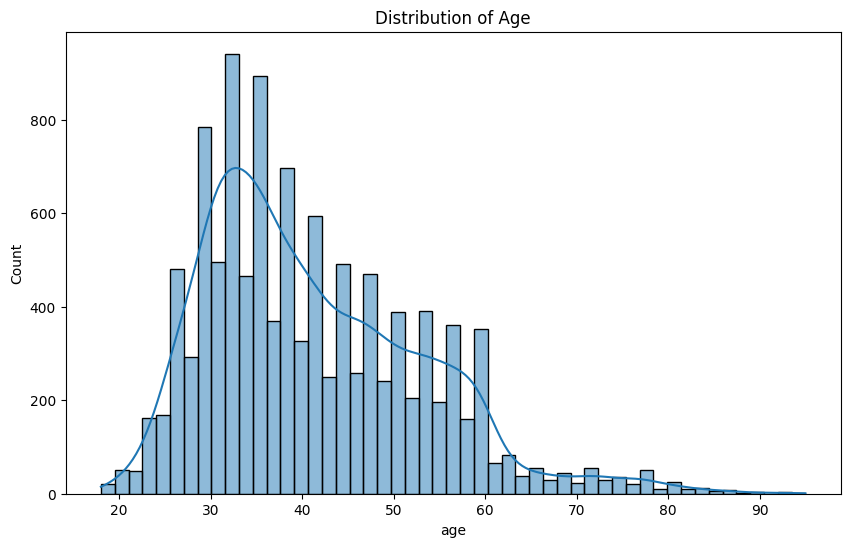

In [14]:
# Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True)
plt.title('Distribution of Age')
plt.show()

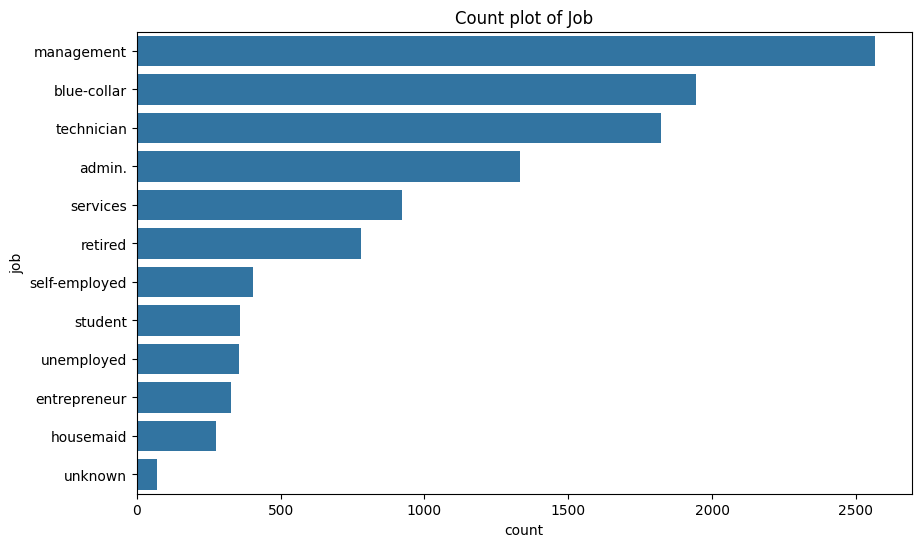

In [15]:
# Count plot for job
plt.figure(figsize=(10, 6))
sns.countplot(y=df['job'], order=df['job'].value_counts().index)
plt.title('Count plot of Job')
plt.show()

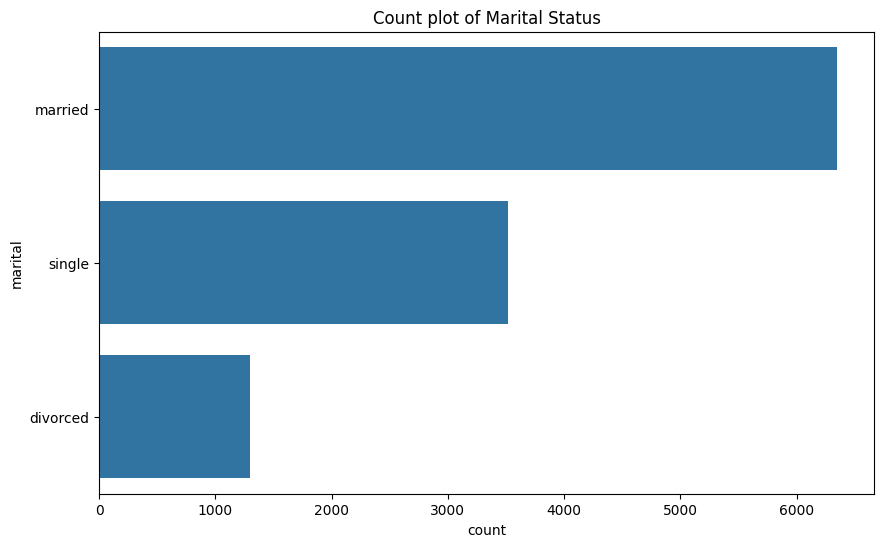

In [16]:
# Count plot for marital
plt.figure(figsize=(10, 6))
sns.countplot(y=df['marital'], order=df['marital'].value_counts().index)
plt.title('Count plot of Marital Status')
plt.show()

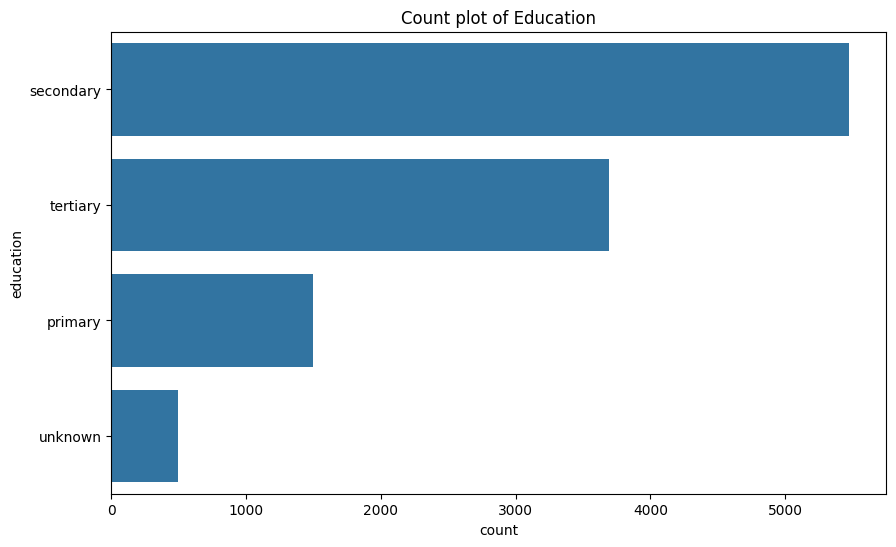

In [17]:
# Count plot for education
plt.figure(figsize=(10, 6))
sns.countplot(y=df['education'], order=df['education'].value_counts().index)
plt.title('Count plot of Education')
plt.show()

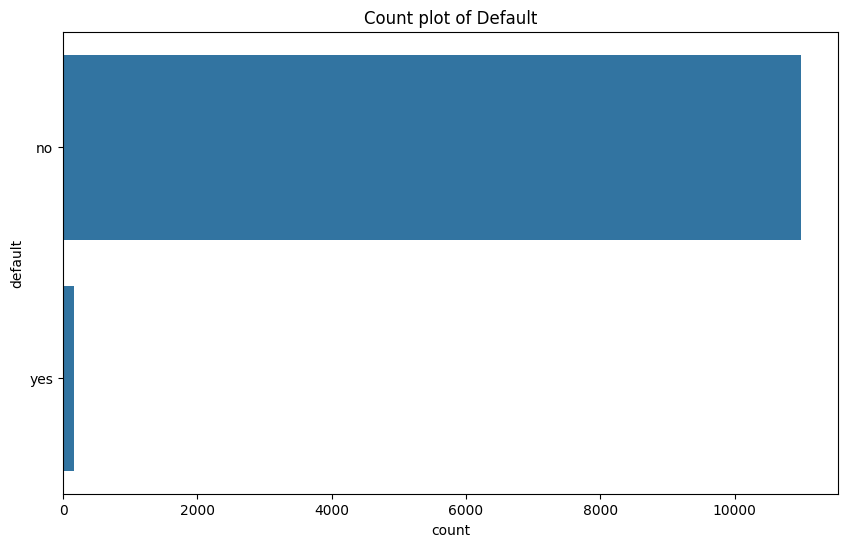

In [18]:
# Count plot for default
plt.figure(figsize=(10, 6))
sns.countplot(y=df['default'], order=df['default'].value_counts().index)
plt.title('Count plot of Default')
plt.show()

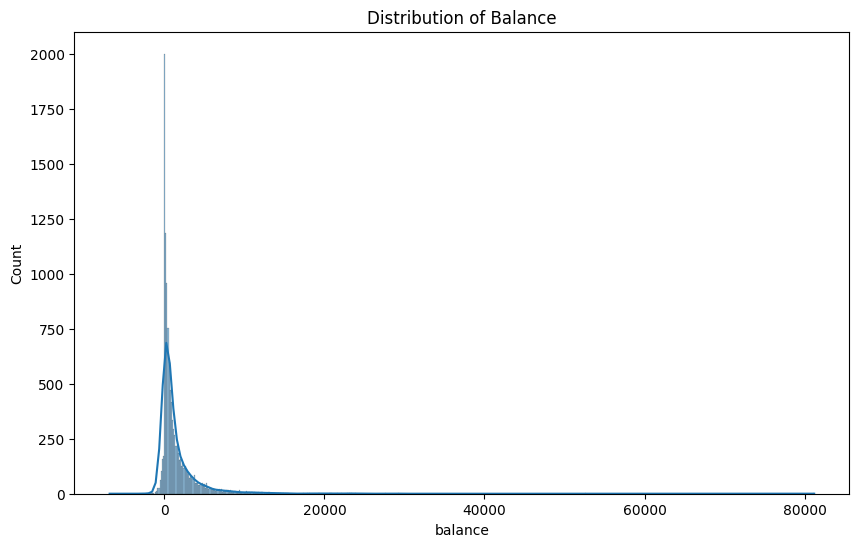

In [19]:
# Distribution of balance
plt.figure(figsize=(10, 6))
sns.histplot(df['balance'], kde=True)
plt.title('Distribution of Balance')
plt.show()

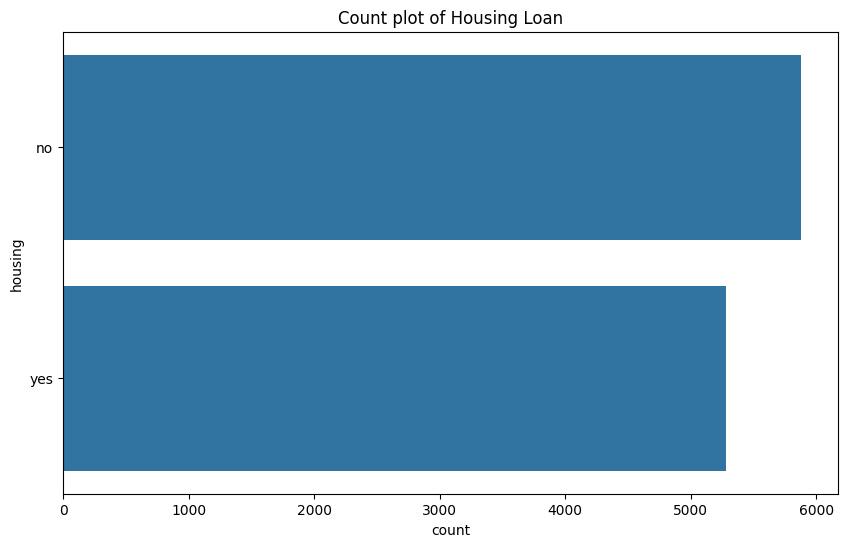

In [20]:
# Count plot for housing
plt.figure(figsize=(10, 6))
sns.countplot(y=df['housing'], order=df['housing'].value_counts().index)
plt.title('Count plot of Housing Loan')
plt.show()

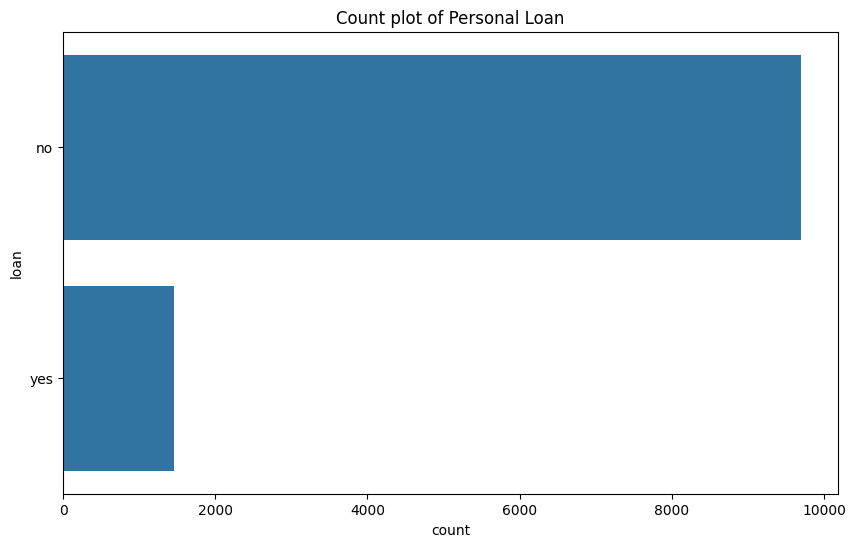

In [21]:
# Count plot for loan
plt.figure(figsize=(10, 6))
sns.countplot(y=df['loan'], order=df['loan'].value_counts().index)
plt.title('Count plot of Personal Loan')
plt.show()

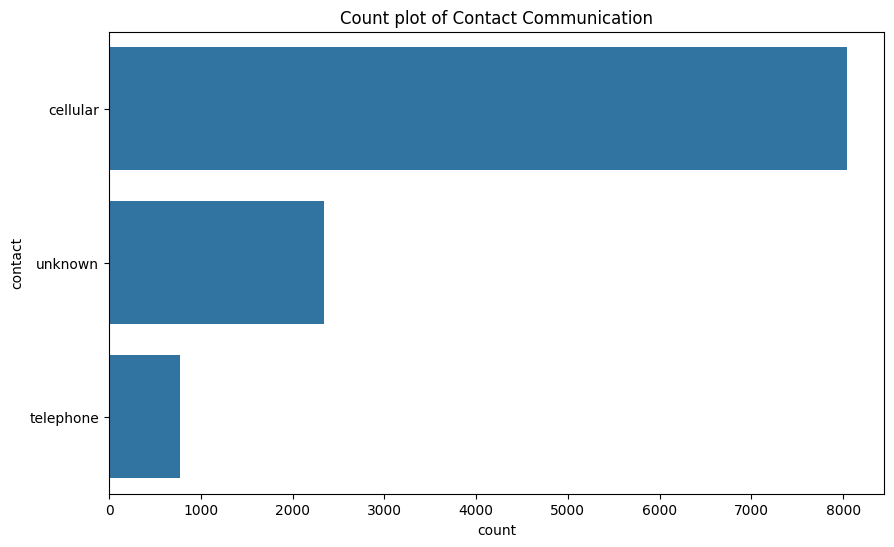

In [22]:
# Count plot for contact
plt.figure(figsize=(10, 6))
sns.countplot(y=df['contact'], order=df['contact'].value_counts().index)
plt.title('Count plot of Contact Communication')
plt.show()

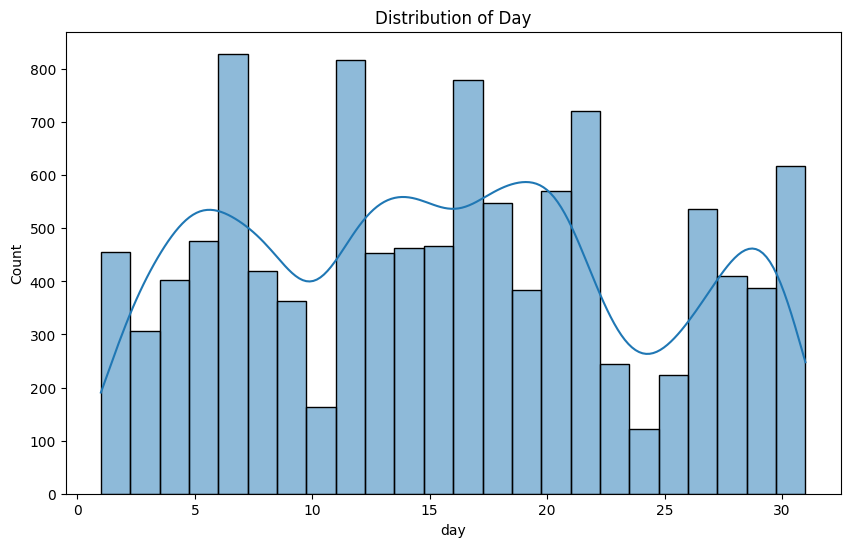

In [23]:
# Distribution of day
plt.figure(figsize=(10, 6))
sns.histplot(df['day'], kde=True)
plt.title('Distribution of Day')
plt.show()

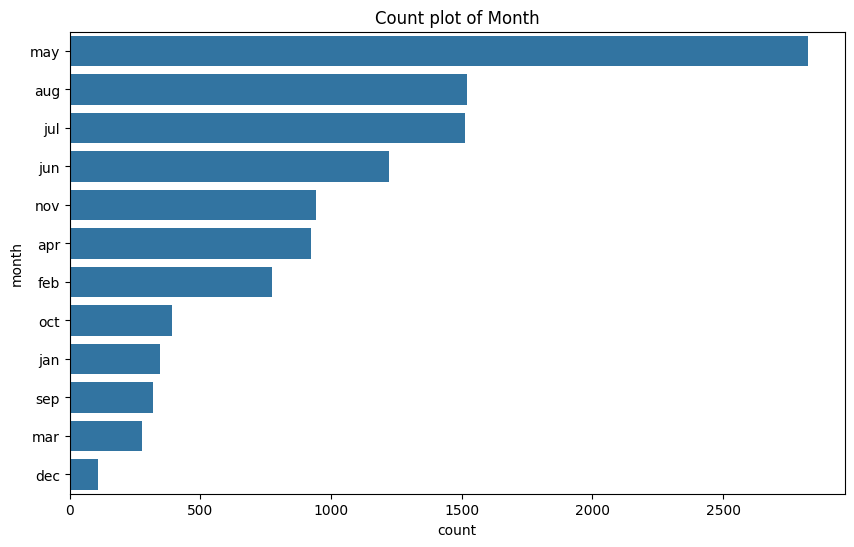

In [24]:
# Count plot for month
plt.figure(figsize=(10, 6))
sns.countplot(y=df['month'], order=df['month'].value_counts().index)
plt.title('Count plot of Month')
plt.show()

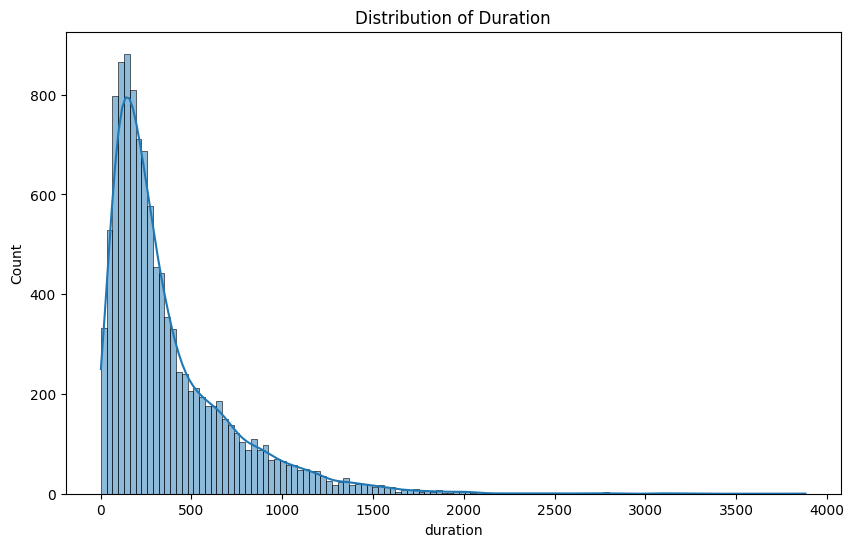

In [25]:
# Distribution of duration
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], kde=True)
plt.title('Distribution of Duration')
plt.show()

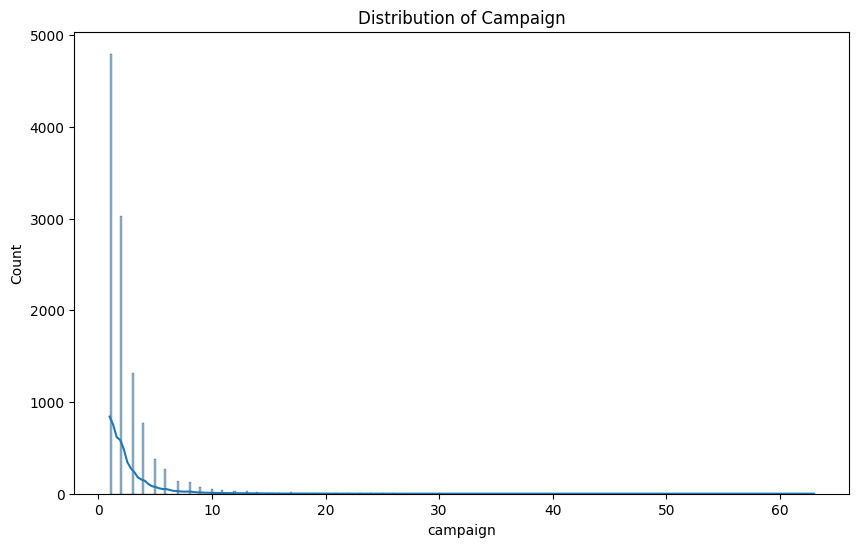

In [26]:
# Distribution of campaign
plt.figure(figsize=(10, 6))
sns.histplot(df['campaign'], kde=True)
plt.title('Distribution of Campaign')
plt.show()

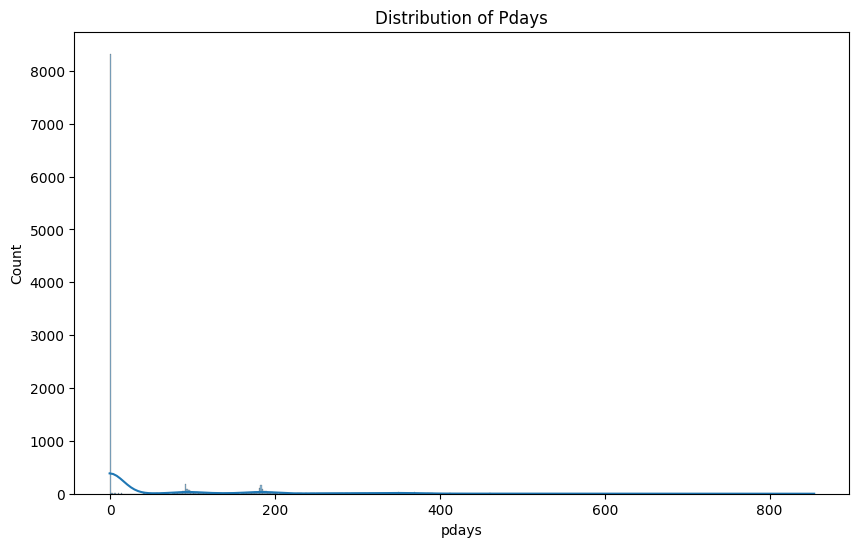

In [27]:
# Distribution of pdays
plt.figure(figsize=(10, 6))
sns.histplot(df['pdays'], kde=True)
plt.title('Distribution of Pdays')
plt.show()

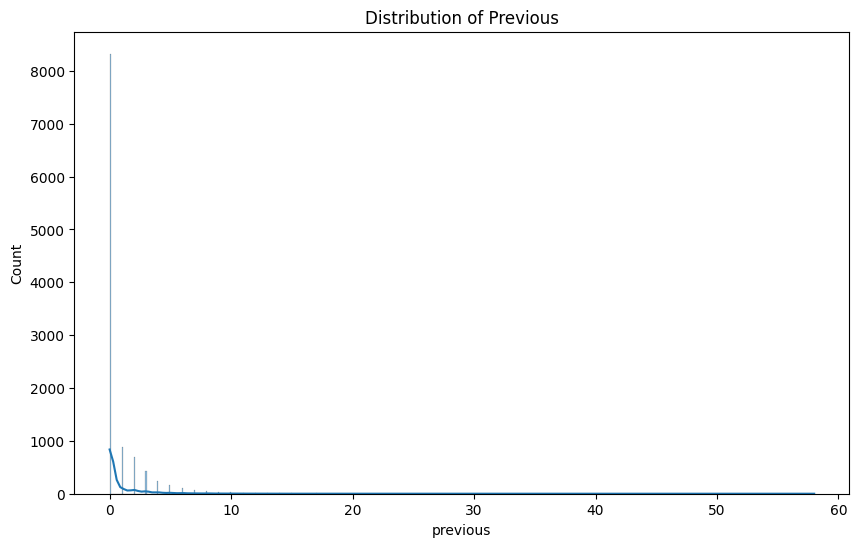

In [28]:
# Distribution of previous
plt.figure(figsize=(10, 6))
sns.histplot(df['previous'], kde=True)
plt.title('Distribution of Previous')
plt.show()

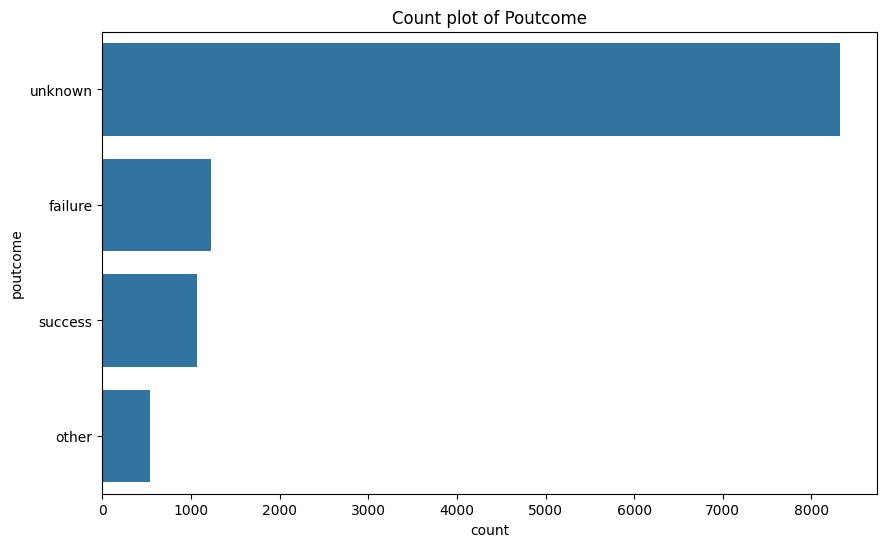

In [29]:
# Count plot for poutcome
plt.figure(figsize=(10, 6))
sns.countplot(y=df['poutcome'], order=df['poutcome'].value_counts().index)
plt.title('Count plot of Poutcome')
plt.show()

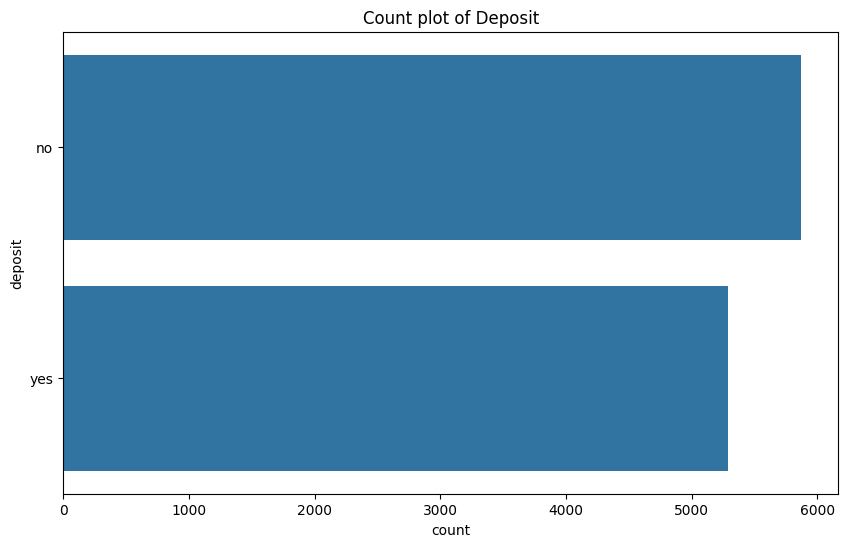

In [30]:
# Count plot for deposit
plt.figure(figsize=(10, 6))
sns.countplot(y=df['deposit'], order=df['deposit'].value_counts().index)
plt.title('Count plot of Deposit')
plt.show()

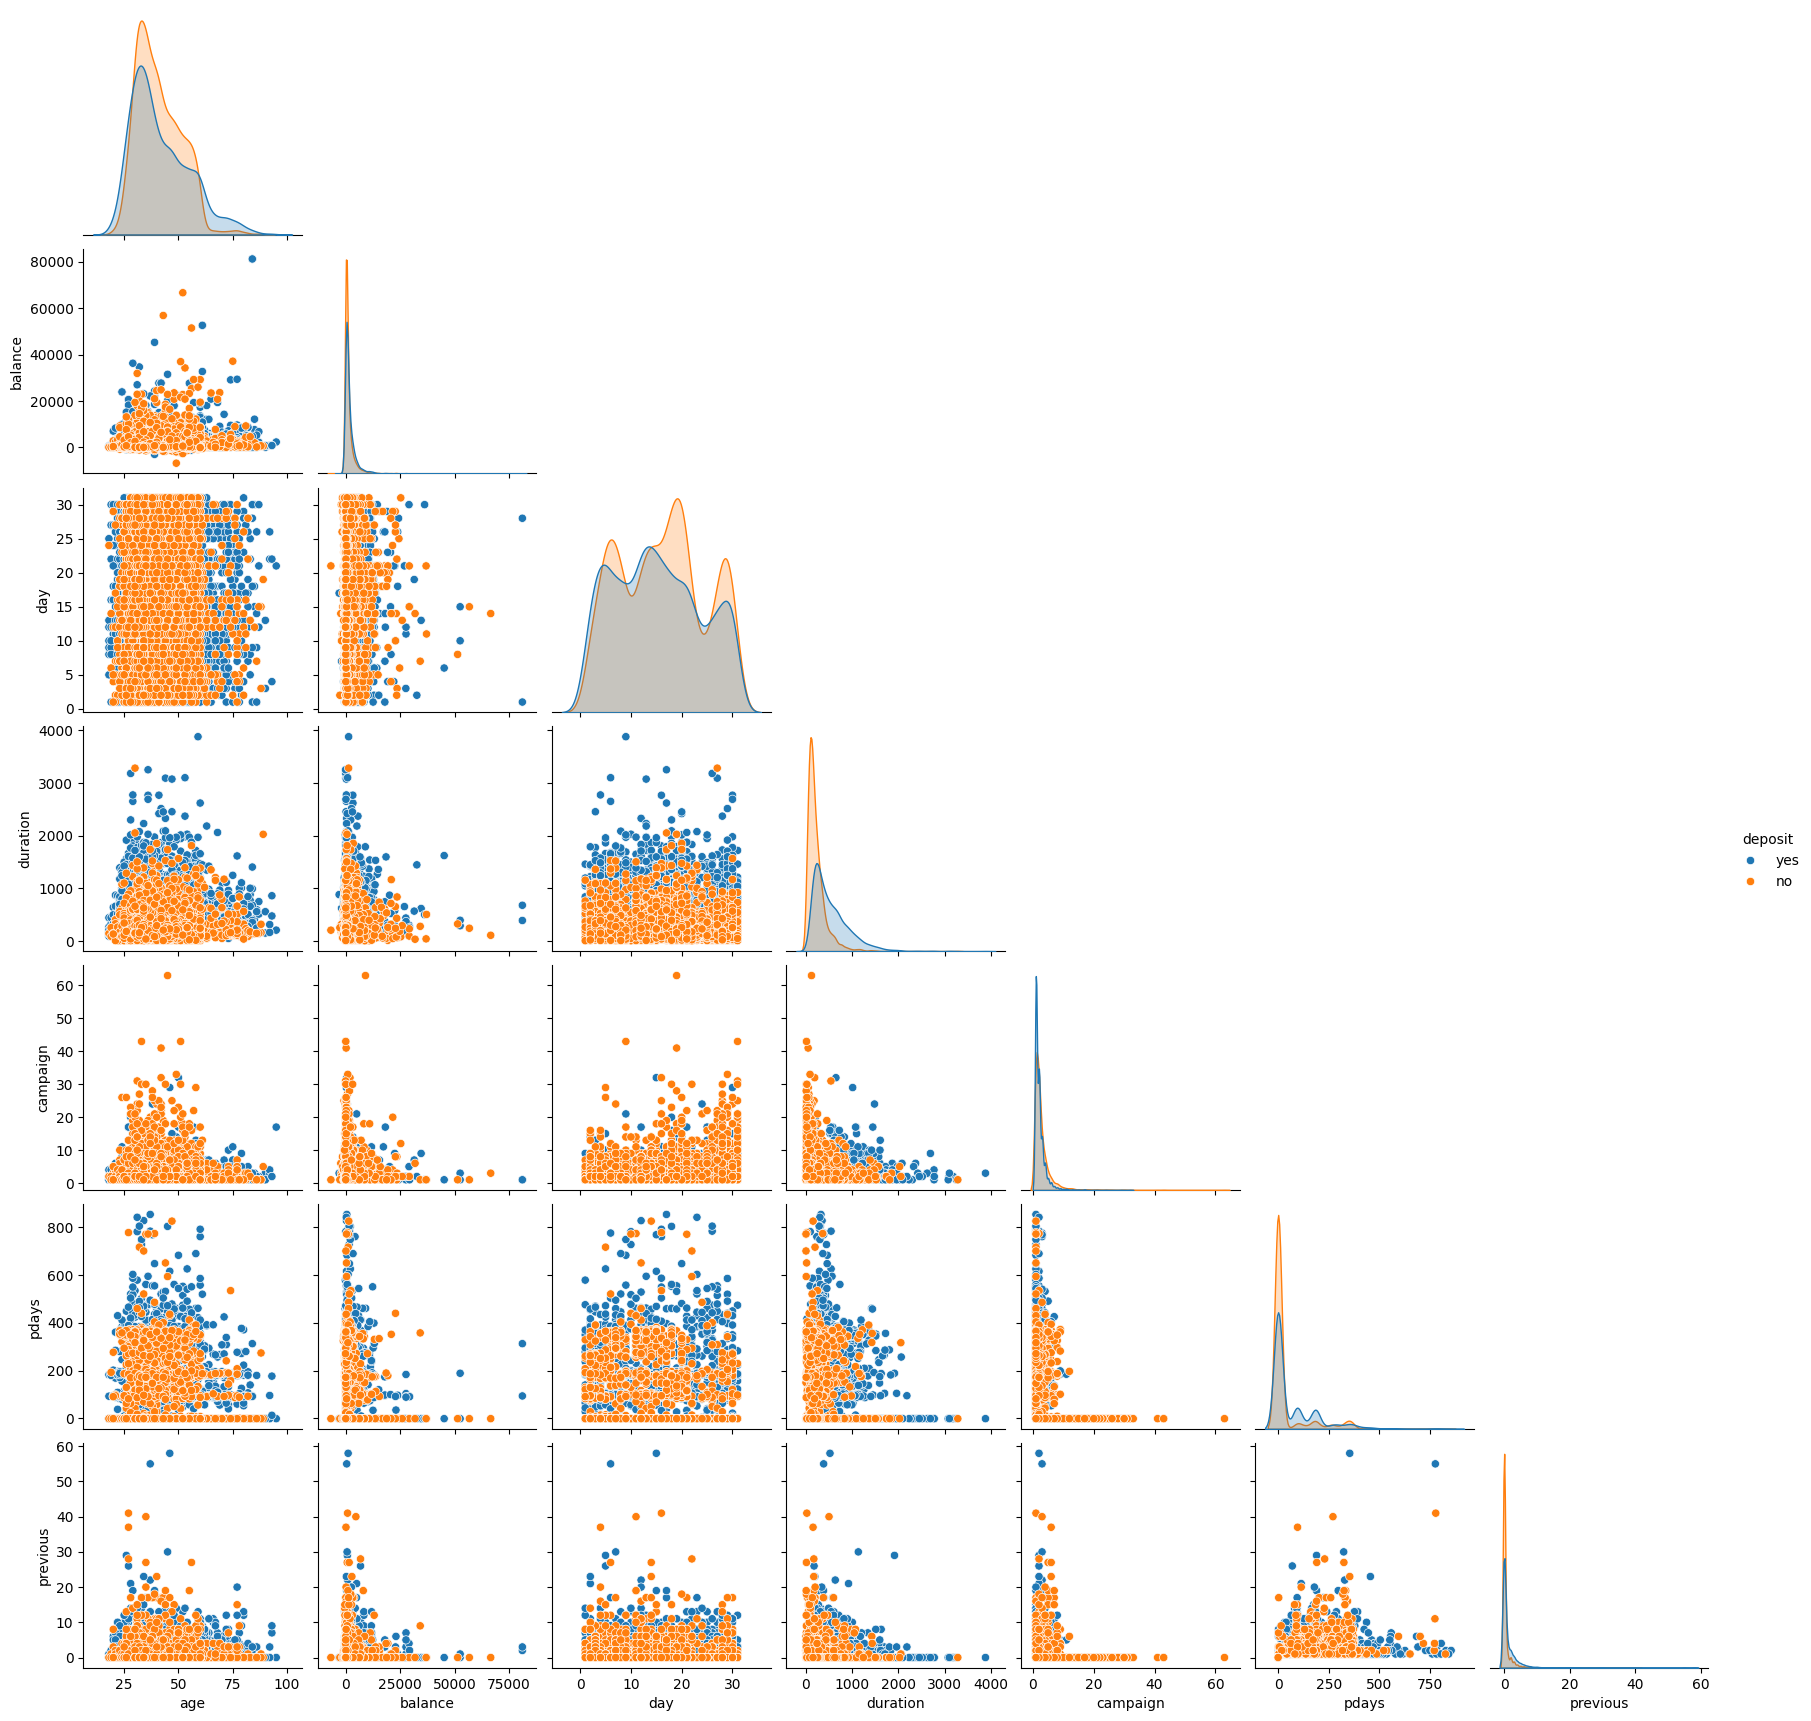

In [31]:
# Create a pairplot to see the relationship with desposits versus not
sns.pairplot(df,hue='deposit',corner=True)

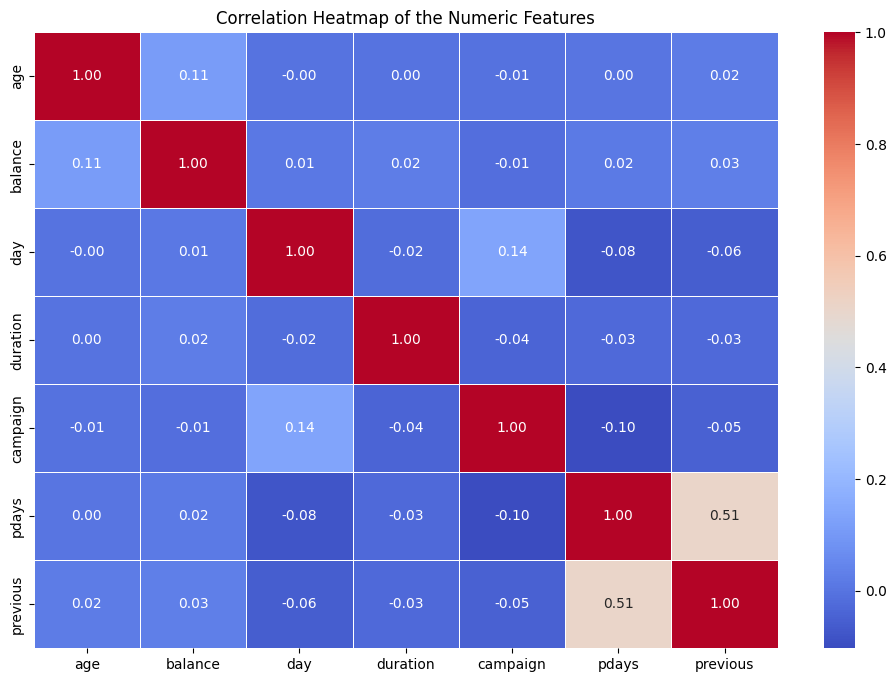

In [32]:
# Create the heatmap
numeric_df = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of the Numeric Features')
plt.show()

The only two numeric variables that seem to have some multicolinearity are previous and pdays. Previous is the number of contacts performed before this campaign and for this client. Pdays is the number of days that passed by after the client was last contacted from a previous campaign. It would make sense that these two variables have some correlation.





Let's investigate the relationship between job and balance.

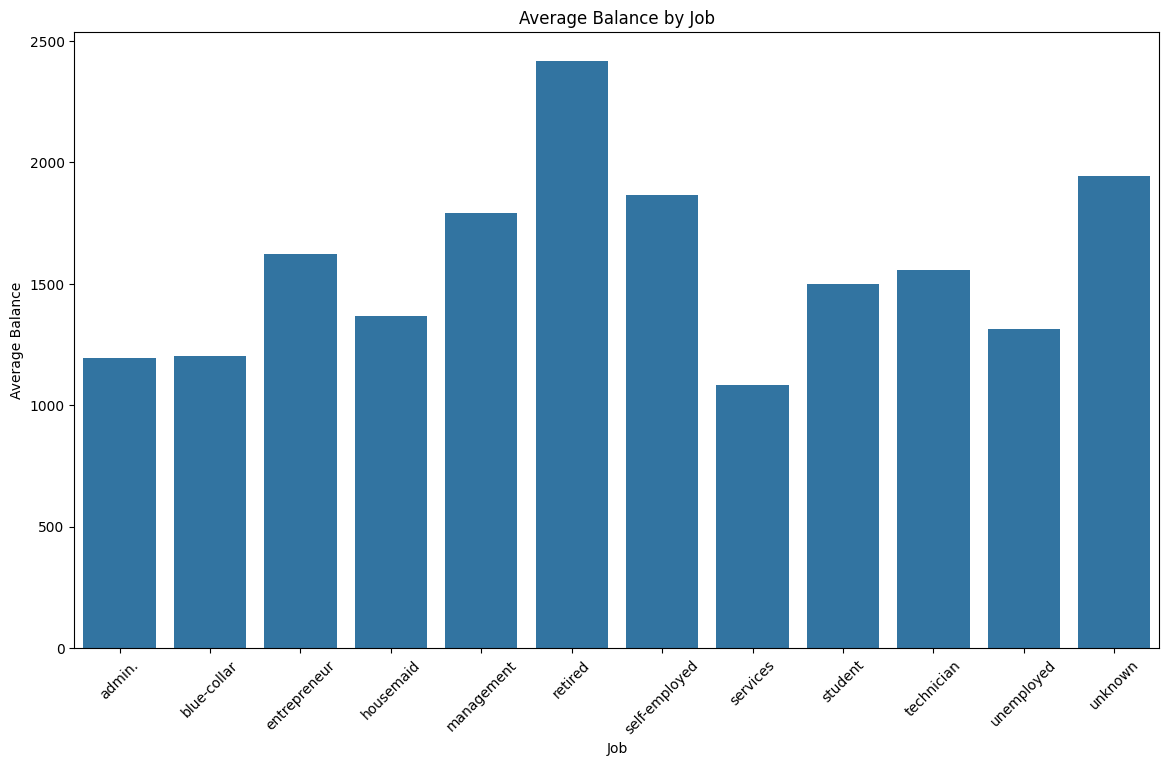

In [33]:
# Create a bar chart
average_balance_by_job = df.groupby('job')['balance'].mean().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x='job', y='balance', data=average_balance_by_job)
plt.title('Average Balance by Job')
plt.xlabel('Job')
plt.ylabel('Average Balance')
plt.xticks(rotation=45)  # Rotate x labels for better readability
plt.show()

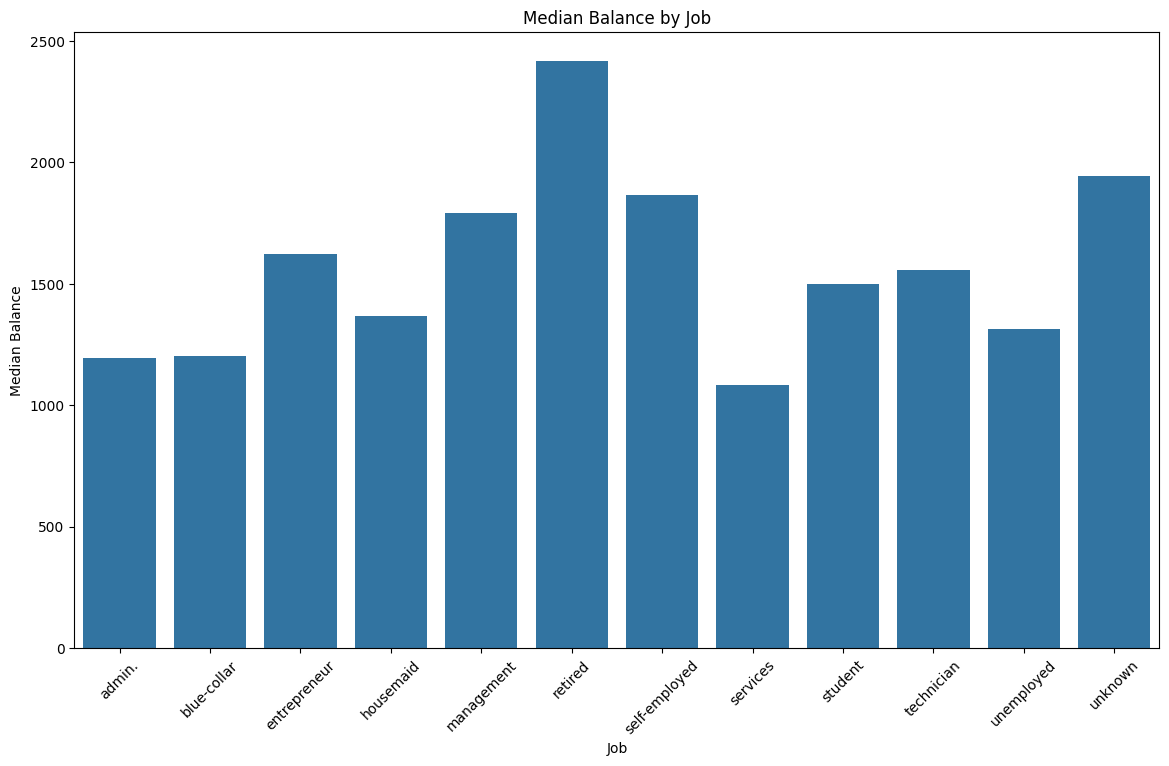

In [34]:
# Create a bar chart
median_balance_by_job = df.groupby('job')['balance'].median().reset_index()
plt.figure(figsize=(14, 8))
sns.barplot(x='job', y='balance', data=average_balance_by_job)
plt.title('Median Balance by Job')
plt.xlabel('Job')
plt.ylabel('Median Balance')
plt.xticks(rotation=45)
plt.show()

Those with the highest mean and median balances are retired. This is followed by unknown jobs and self-employed jobs. The self-employed jobs often includes business owners. Finally, we see the first traditional job category as management jobs as the next highest mean and median balance value.

Let's take a look at the relationship between balance and education level.

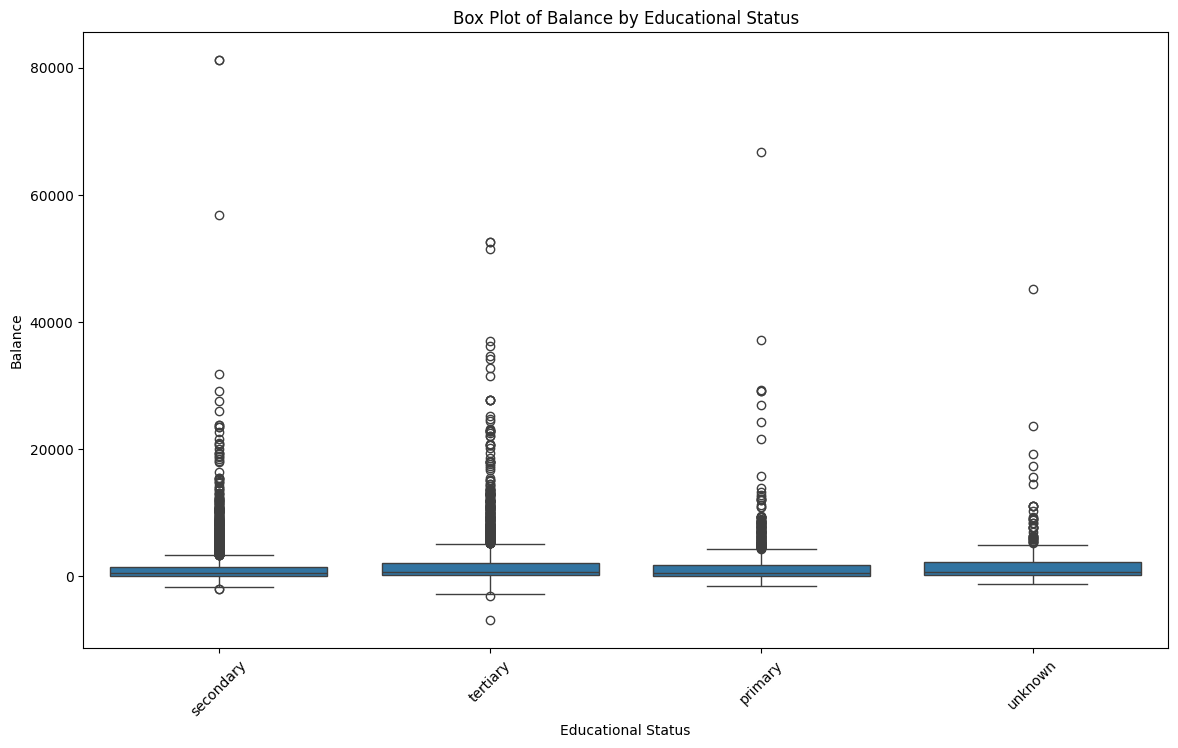

In [35]:
# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='education', y='balance', data=df)
plt.title('Box Plot of Balance by Educational Status')
plt.xlabel('Educational Status')
plt.ylabel('Balance')
plt.xticks(rotation=45)
plt.show()

This does not show much because of the outliers, let's decrease the y-axis limits to get a zoomed in version of the box plot.

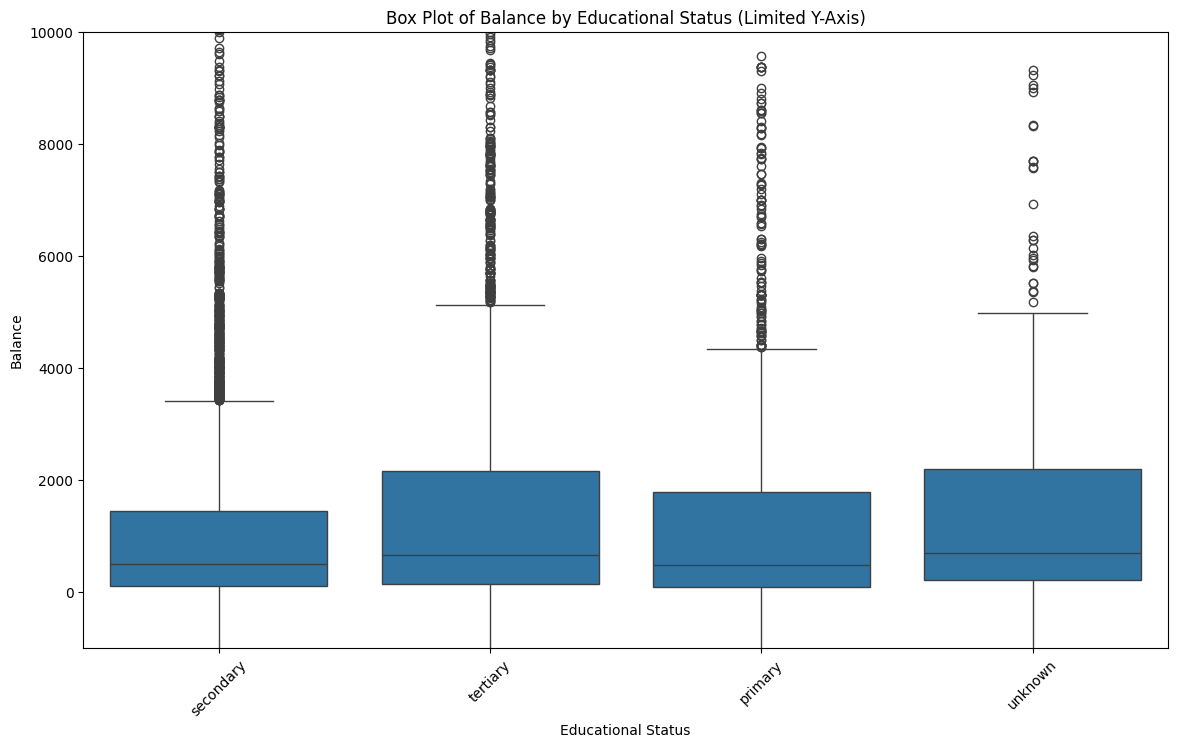

In [36]:
# Create a box plot with adjusted y-axis limits
plt.figure(figsize=(14, 8))
sns.boxplot(x='education', y='balance', data=df)
plt.ylim(-1000, 10000)  # Adjust the limits based on the data distribution
plt.title('Box Plot of Balance by Educational Status (Limited Y-Axis)')
plt.xlabel('Educational Status')
plt.ylabel('Balance')
plt.xticks(rotation=45)
plt.show()

<ipython-input-37-1a5c1aa67c96>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='education', y='balance', data=average_balance_by_education, palette='viridis')


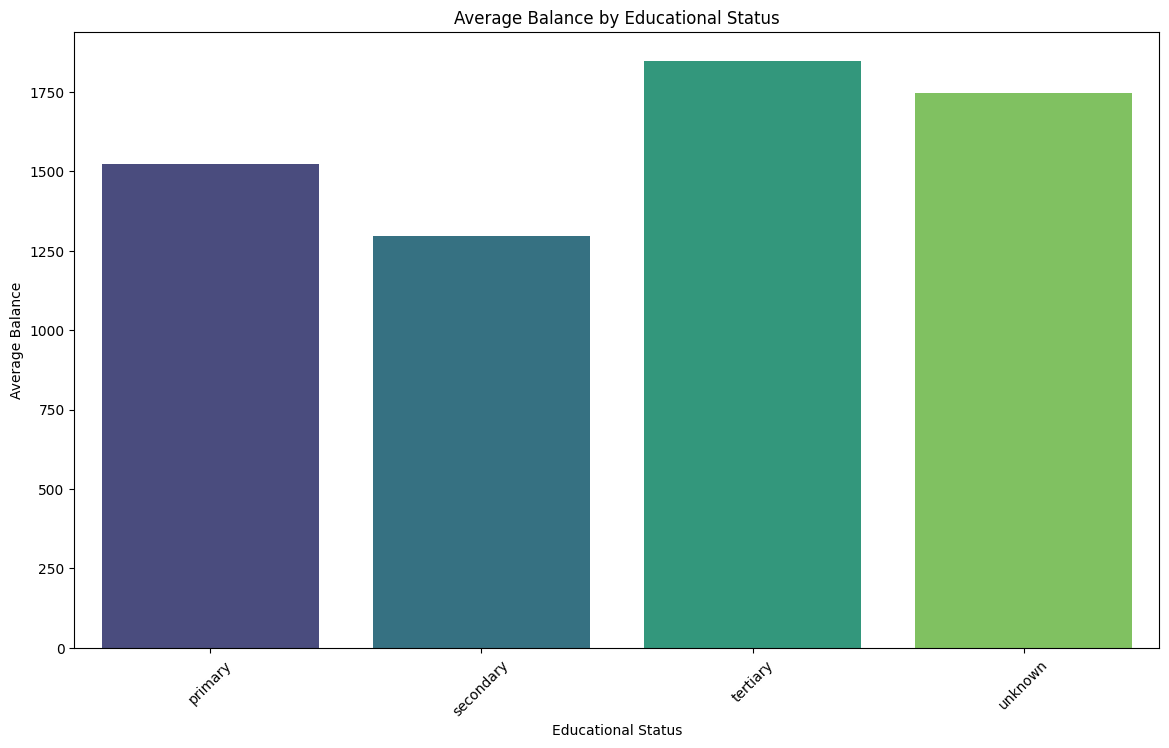

In [37]:
# Calculate the average balance for each education category
average_balance_by_education = df.groupby('education')['balance'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='education', y='balance', data=average_balance_by_education, palette='viridis')
plt.title('Average Balance by Educational Status')
plt.xlabel('Educational Status')
plt.ylabel('Average Balance')
plt.xticks(rotation=45)
plt.show()

In [38]:
# Group the data by educational status and calculate summary statistics for balance
education_balance_summary = df.groupby('education')['balance'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rename columns for clarity
education_balance_summary.rename(columns={'50%': 'median', '25%': '25%', '75%': '75%'}, inplace=True)

# Select and reorder columns
education_balance_summary = education_balance_summary[['education', 'min', '25%', 'median', 'mean', '75%', 'max', 'std']]

# Display the table
print(education_balance_summary)

   education     min    25%  median         mean      75%      max  \
0    primary -1489.0   80.5   472.0  1523.031333  1792.50  66653.0   
1  secondary -1965.0  113.0   494.0  1296.480278  1436.25  81204.0   
2   tertiary -6847.0  147.0   658.0  1845.869070  2155.00  52587.0   
3    unknown -1137.0  209.0   694.0  1746.605634  2193.00  45248.0   

           std  
0  3283.888725  
1  2901.555021  
2  3598.763380  
3  3299.007498  


Based on both the visualizations as well as the tabluar data, it is clear that there is a relationship between education level and balance in the account. Higher education levels (beginning with primary and ending at tertiary) have high median balances in their accounts.

Interestingly, the standard deviation of tertiary is the highest, and the mean for those with a primary education is higher than for those with a secondary education.

Let's see if there seems to be any relationship between deposit and balance in the account.

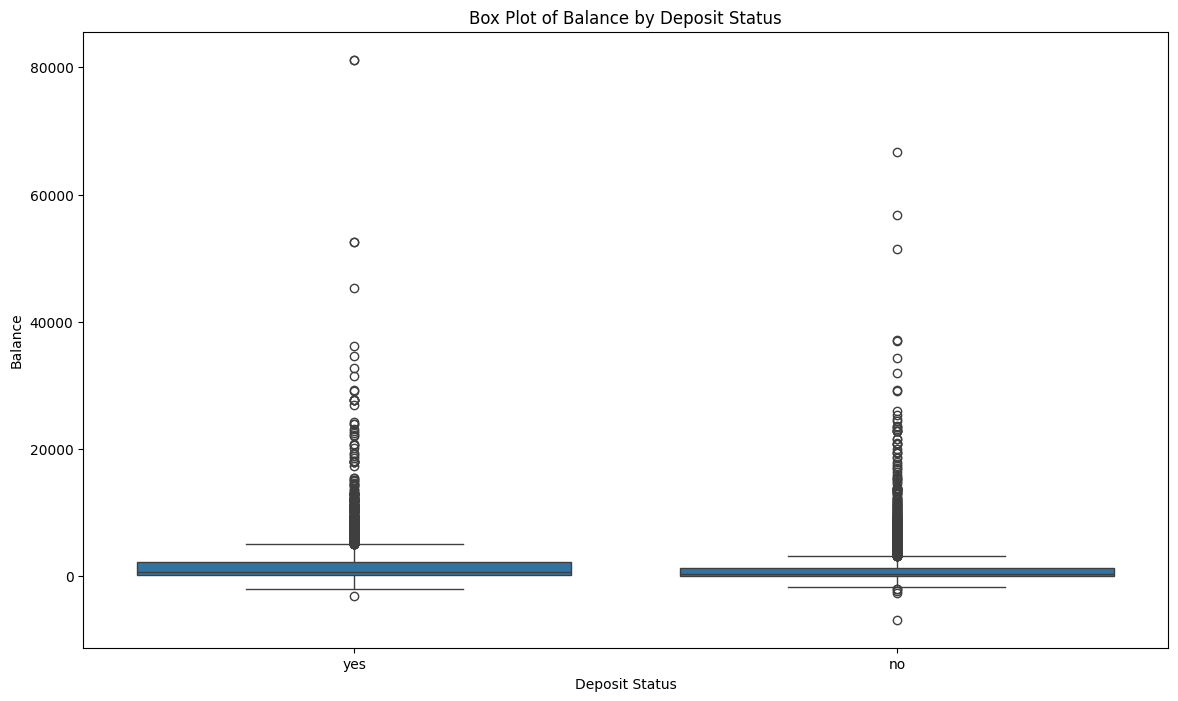

In [39]:
# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='deposit', y='balance', data=df)
plt.title('Box Plot of Balance by Deposit Status')
plt.xlabel('Deposit Status')
plt.ylabel('Balance')
plt.show()

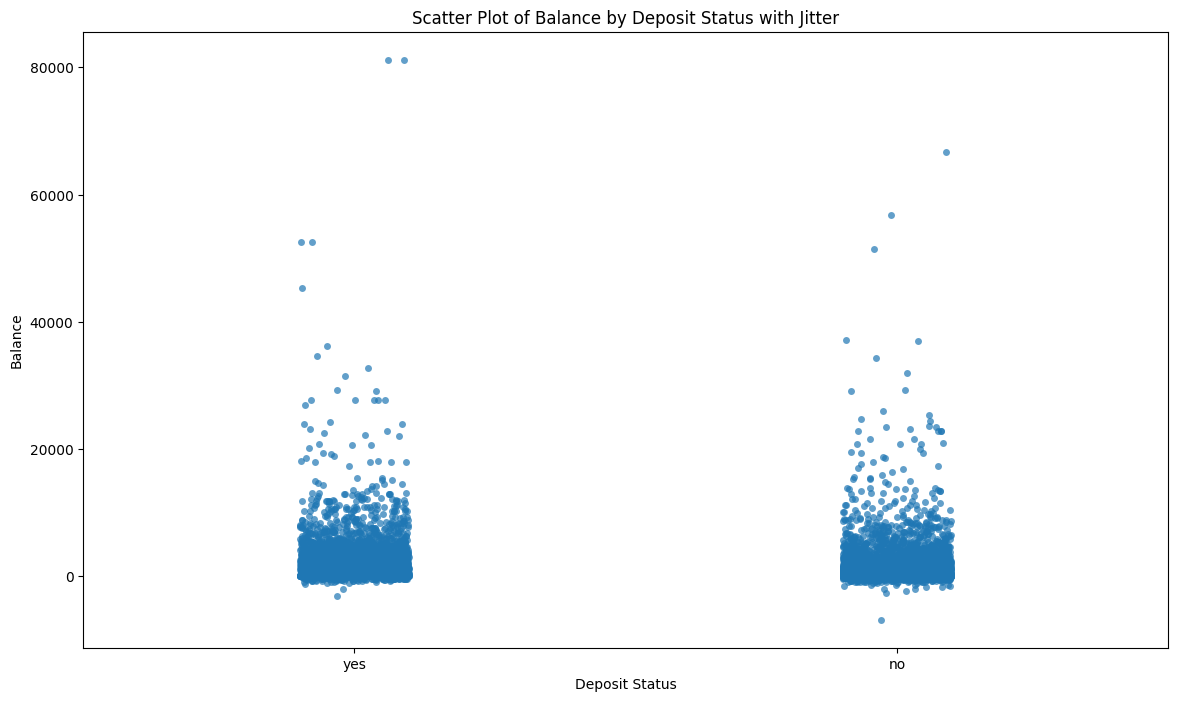

In [40]:
# Create a scatter plot with jitter
plt.figure(figsize=(14, 8))
sns.stripplot(x='deposit', y='balance', data=df, jitter=True, alpha=0.7)
plt.title('Scatter Plot of Balance by Deposit Status with Jitter')
plt.xlabel('Deposit Status')
plt.ylabel('Balance')
plt.show()

In [41]:
# Group the data by deposit status and calculate summary statistics for balance
deposit_balance_summary = df.groupby('deposit')['balance'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rename columns for clarity
deposit_balance_summary.rename(columns={'50%': 'median', '25%': '25%', '75%': '75%'}, inplace=True)

# Select and reorder columns
deposit_balance_summary = deposit_balance_summary[['deposit', 'min', '25%', 'median', 'mean', '75%', 'max']]

# Display the table
print(deposit_balance_summary)

  deposit     min    25%  median         mean     75%      max
0      no -6847.0   64.0   414.0  1280.227141  1324.0  66653.0
1     yes -3058.0  210.0   733.0  1804.267915  2159.0  81204.0


From the plots, we do not get much information at all. It is hard to say if there is any relationship between the two. But, the tablular data says otherwise. The tablular data shows that people with a higher balance in their bank account are more likely to place a deposit into their account at the bank in the term since the campaign began.

This should indicate to the marketing team a couple of options. First, they could market to those with a higher balance because they are going to deposit more frequently. They could also target those with lower balances to try to get them to make more deposits.

Let's explore the relationship between campaign (the number of contacts performed during this campaign and for this client) and deposit.


<ipython-input-42-89f54bdda294>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='deposit', y='campaign', data=df, estimator='mean', ci=None)


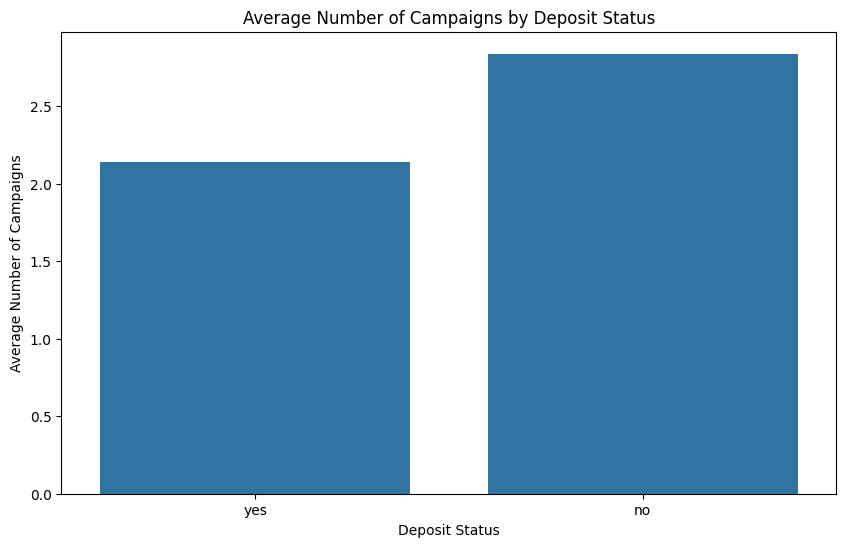

In [42]:
# Create a bar plot to show the average number of campaigns for each deposit status
plt.figure(figsize=(10, 6))
sns.barplot(x='deposit', y='campaign', data=df, estimator='mean', ci=None)
plt.title('Average Number of Campaigns by Deposit Status')
plt.xlabel('Deposit Status')
plt.ylabel('Average Number of Campaigns')
plt.show()

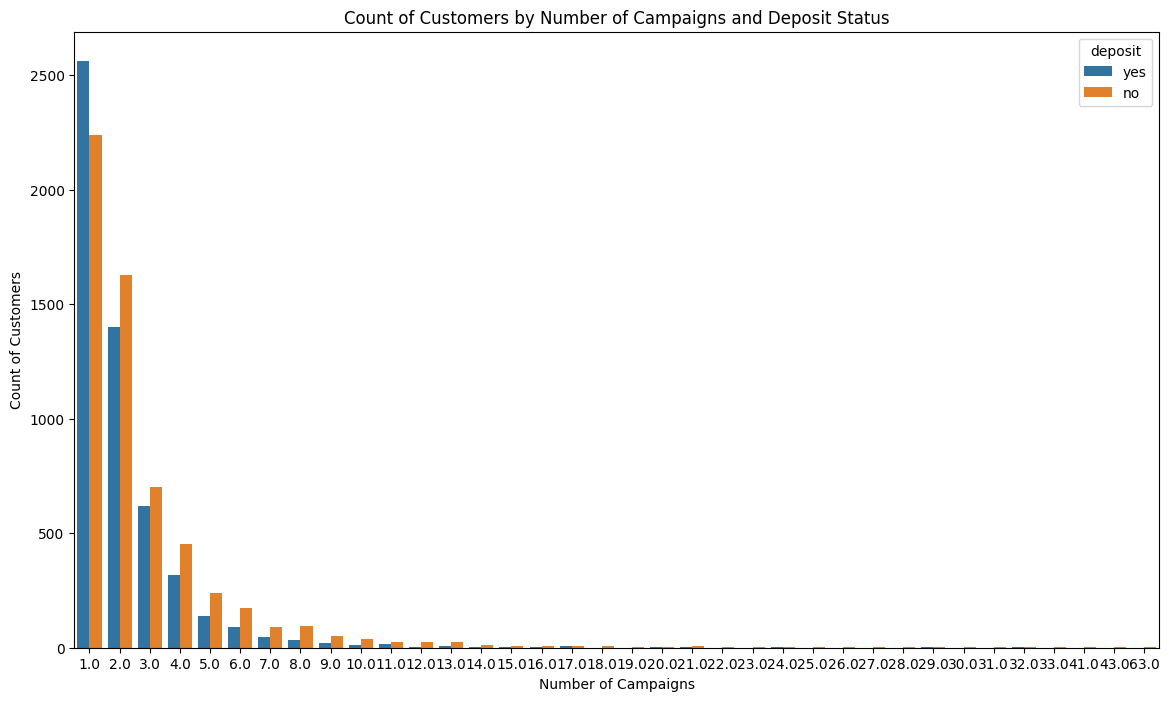

In [43]:
# Create a count plot to show the count of customers for each number of campaigns, split by deposit status
plt.figure(figsize=(14, 8))
sns.countplot(x='campaign', hue='deposit', data=df)
plt.title('Count of Customers by Number of Campaigns and Deposit Status')
plt.xlabel('Number of Campaigns')
plt.ylabel('Count of Customers')
plt.show()

<ipython-input-44-376e22fae882>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='campaign', y='ratio', data=campaign_deposit_counts, palette='viridis', alpha=0.7)


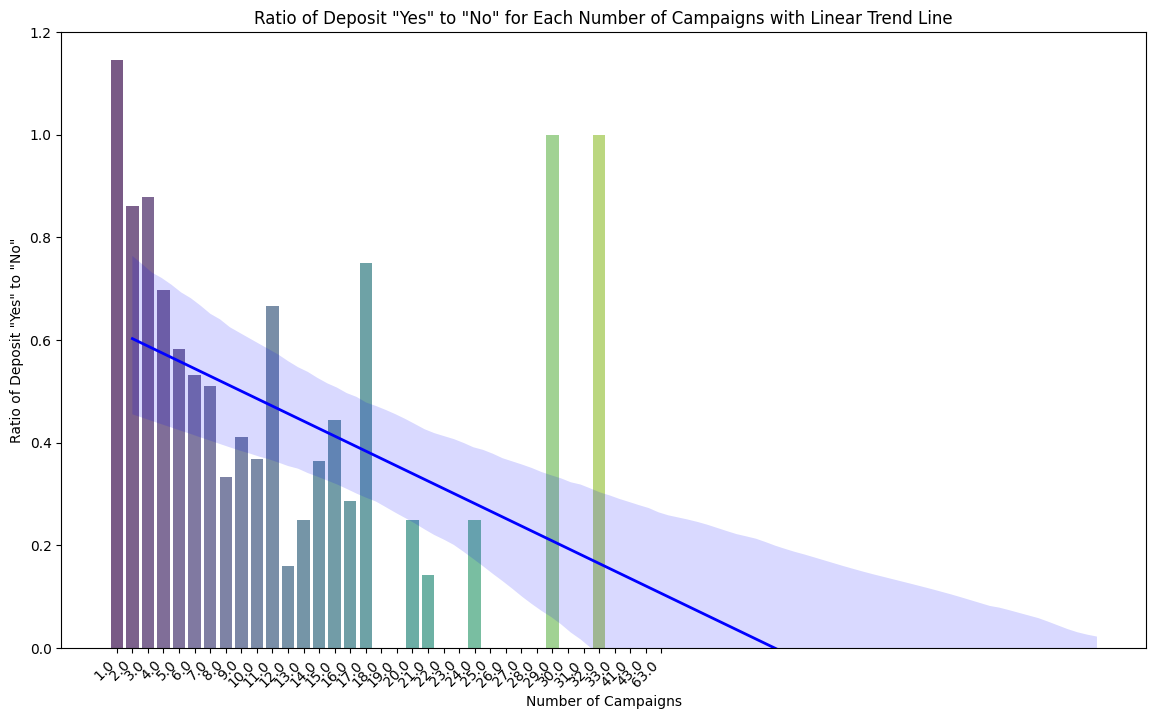

In [44]:
# Calculate the count of deposit "yes" and "no" for each number of campaigns
campaign_deposit_counts = df.groupby(['campaign', 'deposit']).size().unstack(fill_value=0)

# Calculate the ratio of "yes" to "no" for each campaign count
campaign_deposit_counts['ratio'] = campaign_deposit_counts['yes'] / campaign_deposit_counts['no']

# Replace infinite values with NaN (happens when 'no' count is 0) and drop them
campaign_deposit_counts.replace([np.inf, -np.inf], np.nan, inplace=True)
campaign_deposit_counts.dropna(subset=['ratio'], inplace=True)

# Reset the index for plotting
campaign_deposit_counts.reset_index(inplace=True)

# Plot the ratios
plt.figure(figsize=(14, 8))
sns.barplot(x='campaign', y='ratio', data=campaign_deposit_counts, palette='viridis', alpha=0.7)

# Fit a linear regression model
sns.regplot(x='campaign', y='ratio', data=campaign_deposit_counts, scatter=False, color='blue', line_kws={"lw": 2})

plt.title('Ratio of Deposit "Yes" to "No" for Each Number of Campaigns with Linear Trend Line')
plt.xlabel('Number of Campaigns')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Ratio of Deposit "Yes" to "No"')
plt.ylim(0, 1.2)
plt.show()

In [45]:
# Group by deposit status and calculate summary statistics for the campaign variable
campaign_summary = df.groupby('deposit')['campaign'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rename columns for clarity
campaign_summary.rename(columns={'50%': 'median', '25%': '25%', '75%': '75%'}, inplace=True)

# Reorder columns
campaign_summary = campaign_summary[['deposit', 'count', 'mean', 'std', 'min', '25%', 'median', '75%', 'max']]

# Display the table
print(campaign_summary)


  deposit   count      mean       std  min  25%  median  75%   max
0      no  5873.0  2.839264  3.244474  1.0  1.0     2.0  3.0  63.0
1     yes  5289.0  2.141047  1.921826  1.0  1.0     2.0  3.0  32.0


From the graphical data, we can take away a few things. From the bar chart, we find that on average, those who did not deposit money during the campaign were actually contacted more than those who did campaign. This could be because once someone deposited during the campaign the bank stopped contacting them with the campaign advertising, while continuing to pursue deposits from those who did not deposit.

The second chart shows a couple of things. First, the only number of campaign contacts where a deposit happened more than not depositing was just one contact. Otherwise, the number of non-deposits was higher as the number of contacts during the campaign increased. This chart also shows that maybe more is less, which is further argued through the third chart. This chart shows the ratio between 'yes' and 'no' for deposits made during the marketing campaihn as the number of contacts increases. As the trend line shows, there is typically a decrease in the ratio of yes's compared to no's as the number of contacts goes up.

Finally, the numeric data shows that there is not a massive difference between contacts and deposits, although the mean contacts for no's is higher than yes's.

Let's now take a look at the relationship between if people had a home loan and whether or not they made a deposit.

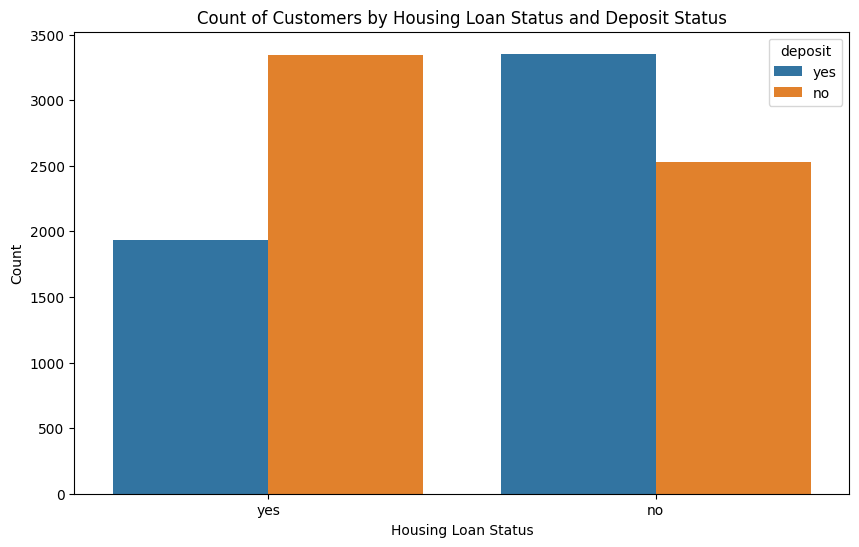

In [46]:
# Create a count plot
plt.figure(figsize=(10, 6))
sns.countplot(x='housing', hue='deposit', data=df)
plt.title('Count of Customers by Housing Loan Status and Deposit Status')
plt.xlabel('Housing Loan Status')
plt.ylabel('Count')
plt.show()

<Figure size 1000x600 with 0 Axes>

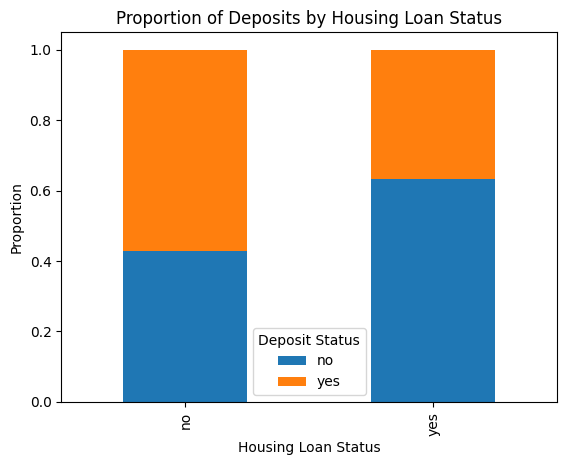

In [47]:
# Calculate the proportion of deposits for each housing loan status
housing_deposit_proportions = df.groupby('housing')['deposit'].value_counts(normalize=True).unstack().fillna(0)

# Plot the proportions
plt.figure(figsize=(10, 6))
housing_deposit_proportions.plot(kind='bar', stacked=True)
plt.title('Proportion of Deposits by Housing Loan Status')
plt.xlabel('Housing Loan Status')
plt.ylabel('Proportion')
plt.legend(title='Deposit Status')
plt.show()

Clearly, from both of the charts, people without a housing loan during the marketing campaign made deposits more, while those who had a housing loan made less deposits during the marketing campaign.

Let's investigate the relationship between duration (last contact duration, in seconds) and deposit.

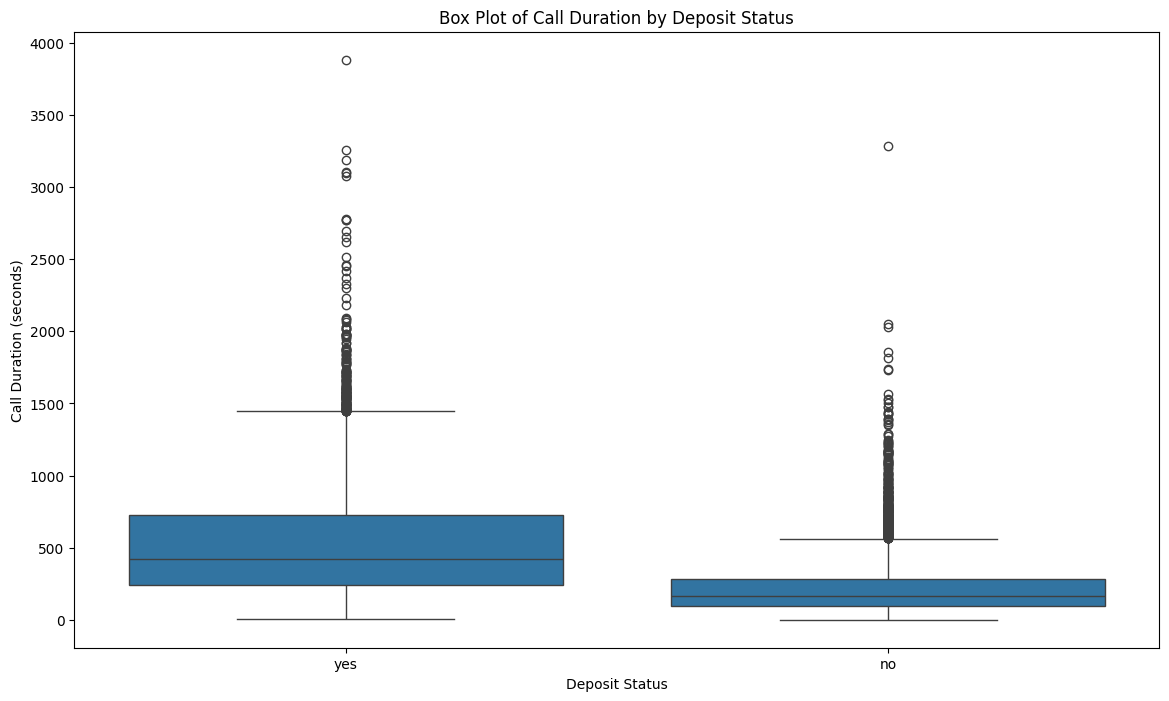

In [48]:
# Create a box plot
plt.figure(figsize=(14, 8))
sns.boxplot(x='deposit', y='duration', data=df)
plt.title('Box Plot of Call Duration by Deposit Status')
plt.xlabel('Deposit Status')
plt.ylabel('Call Duration (seconds)')
plt.show()

In [49]:
# Calculate summary statistics for call duration by deposit status
duration_summary = df.groupby('deposit')['duration'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rename columns for clarity
duration_summary.rename(columns={'50%': 'median', '25%': '25%', '75%': '75%'}, inplace=True)

# Reorder columns
duration_summary = duration_summary[['deposit', 'count', 'min', '25%', 'median', 'mean', '75%', 'max']]

# Display the summary table
print(duration_summary)

  deposit   count  min    25%  median        mean    75%     max
0      no  5873.0  2.0   94.0   163.0  223.130257  282.0  3284.0
1     yes  5289.0  8.0  244.0   426.0  537.294574  725.0  3881.0


Here, both the box plot and the tabular data show that there seems to be a relationship between deposit status and duration of the call. The longer the call, the more often someone deposited. Every single statistic in the table has a higher value in the 'yes' category than in the 'no' category for deposits.


---

### Key Takaways:

*   **Length of the Call Matters.** As the length of the call goes up, so do the odds that they deposit money. The marketing team needs to find ways to keep people hooked and on the phone.
*   **More Money, More Deposits.** People with more money in their accounts tend to deposit more during these campaigns. It might be a good idea to target those with less money in their accounts to try to increase the number of deposits while still making sure the higher balance customers still get their deposits in.
*   **More is Less.** As the number of contacts increased, the ratio of deposits to no deposit decreased on averaged.




## Prep for Model Creation

<ipython-input-50-c255e8d259ae>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='deposit', data=df, palette='viridis')


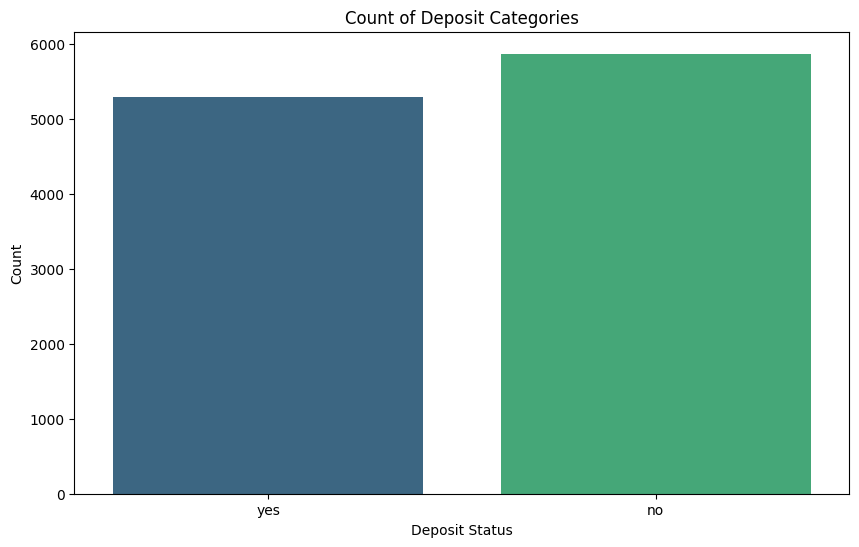

In [50]:
# Look at the target class
plt.figure(figsize=(10, 6))
sns.countplot(x='deposit', data=df, palette='viridis')

plt.title('Count of Deposit Categories')
plt.xlabel('Deposit Status')
plt.ylabel('Count')
plt.show()

Great, we do not have to worry about class imbalance since there is a relatively even number in each class for deposit status.

The next step is to encode our variables. We need to encode categorical variables because the machine learning models only recognize numbers as inputs, not something like 'yes' or 'no.'

In [51]:
# Label Encoding Deposit Column
le = LabelEncoder()
df['deposit'] = le.fit_transform(df['deposit'])

# Check that it worked
df.head()

age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no   2343.0     yes   no  unknown   
1   56      admin.  married  secondary      no     45.0      no   no  unknown   
2   41  technician  married  secondary      no   1270.0     yes   no  unknown   
3   55    services  married  secondary      no   2476.0     yes   no  unknown   
4   54      admin.  married   tertiary      no    184.0      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome  deposit  
0  5.0   may    1042.0       1.0   -1.0       0.0  unknown        1  
1  5.0   may    1467.0       1.0   -1.0       0.0  unknown        1  
2  5.0   may    1389.0       1.0   -1.0       0.0  unknown        1  
3  5.0   may     579.0       1.0   -1.0       0.0  unknown        1  
4  5.0   may     673.0       2.0   -1.0       0.0  unknown        1

So now, 1's are a 'yes' for deposit while 0's are a 'no.'

In [52]:
# Label encode rest of binary categorical variables
binary_categorical_columns = ['default', 'housing', 'loan']

# Label encode each binary categorical column
for column in binary_categorical_columns:
    df[column] = le.fit_transform(df[column])

In [53]:
df.head()

age         job  marital  education  default  balance  housing  loan  \
0   59      admin.  married  secondary        0   2343.0        1     0   
1   56      admin.  married  secondary        0     45.0        0     0   
2   41  technician  married  secondary        0   1270.0        1     0   
3   55    services  married  secondary        0   2476.0        1     0   
4   54      admin.  married   tertiary        0    184.0        0     0   

   contact  day month  duration  campaign  pdays  previous poutcome  deposit  
0  unknown  5.0   may    1042.0       1.0   -1.0       0.0  unknown        1  
1  unknown  5.0   may    1467.0       1.0   -1.0       0.0  unknown        1  
2  unknown  5.0   may    1389.0       1.0   -1.0       0.0  unknown        1  
3  unknown  5.0   may     579.0       1.0   -1.0       0.0  unknown        1  
4  unknown  5.0   may     673.0       2.0   -1.0       0.0  unknown        1

For these new columns, similar to the deposit column, 1's represent 'yes' and 0's represent 'no.'

In [54]:
# One-Hot Encode rest of Categorical Variables
categorical_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=categorical_columns)


In [55]:
# Check that it worked
df.head()

age  default  balance  housing  loan  day  duration  campaign  pdays  \
0   59        0   2343.0        1     0  5.0    1042.0       1.0   -1.0   
1   56        0     45.0        0     0  5.0    1467.0       1.0   -1.0   
2   41        0   1270.0        1     0  5.0    1389.0       1.0   -1.0   
3   55        0   2476.0        1     0  5.0     579.0       1.0   -1.0   
4   54        0    184.0        0     0  5.0     673.0       2.0   -1.0   

   previous  ...  month_jun  month_mar  month_may  month_nov  month_oct  \
0       0.0  ...      False      False       True      False      False   
1       0.0  ...      False      False       True      False      False   
2       0.0  ...      False      False       True      False      False   
3       0.0  ...      False      False       True      False      False   
4       0.0  ...      False      False       True      False      False   

   month_sep  poutcome_failure  poutcome_other  poutcome_success  \
0      False             False           False             False   
1      False             False           False             False   
2      False             False           False             False   
3      False             False           False             False   
4      False             False           False             False   

   poutcome_unknown  
0              True  
1              True  
2              True  
3              True  
4              True  

[5 rows x 49 columns]

In [56]:
# Check Shape
df.shape

(11162, 49)

Because of the one-hot encoding, we added a lot of columns to the dataframe. This is not a problem because we didn't add hundreds or thousands of columns, we added just over 30.

In [57]:
# Split Data into X and y
X = df.drop(columns=['deposit'])
y = df['deposit']

In [58]:
# Scale Data
X_scaled = StandardScaler().fit_transform(X)

# Convert the scaled data back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

Okay, we're ready to create our model!

## Model Creation - Decision Tree Classifier

In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=101)

In [60]:
# Create a decision tree classifier
tree_model = DecisionTreeClassifier(random_state=101)

# Train the decision tree classifier
tree_model.fit(X_train, y_train)

# Evaluate the decision tree model
train_accuracy = tree_model.score(X_train, y_train)
test_accuracy = tree_model.score(X_test, y_test)
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 1.0
Testing Accuracy: 0.7953425884460367


In [61]:
# Testing the data with the created tree
tree_model.fit(X_train,y_train)
y_pred = tree_model.predict(X_test)

In [62]:
# Confusion Matrix
data_cm = confusion_matrix(y_test, y_pred)
print(data_cm)

[[956 225]
 [232 820]]


In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1181
           1       0.78      0.78      0.78      1052

    accuracy                           0.80      2233
   macro avg       0.79      0.79      0.79      2233
weighted avg       0.80      0.80      0.80      2233



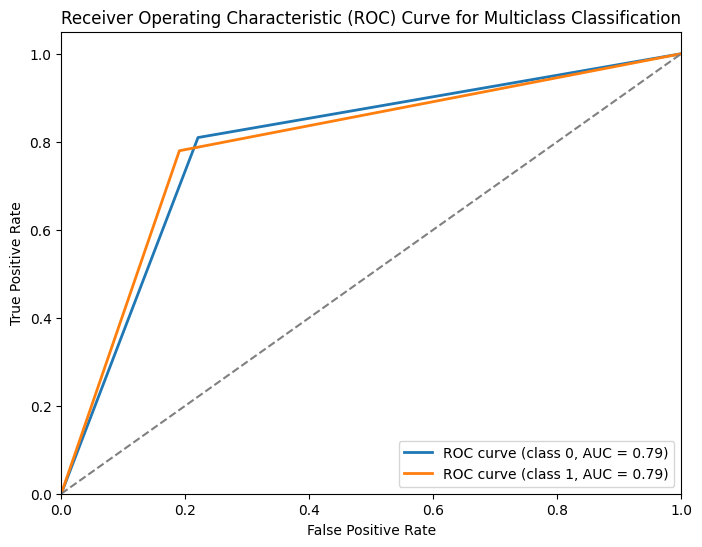

In [64]:
# Calculate ROC curve and AUC score for each class
n_classes = len(tree_model.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    y_test_binary = (y_test == i)  # Create binary target for the current class
    y_prob_class = tree_model.predict_proba(X_test)[:, i]  # Predict probabilities for the current class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_prob_class)
    roc_auc[i] = roc_auc_score(y_test_binary, y_prob_class)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d, AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()

## Tuning the Decision Tree

For tuning the tree, we can use a number of different methods to determine what to use. In this case, we are going to try to maximize accuracy.

In [65]:
# Split Criteria (Entropy or Gini)
results_split = []
recall = []
precision = []
f1 = []
split_options = ["entropy","gini"]
for trees in split_options:
  model = DecisionTreeClassifier(criterion= trees, random_state = 42)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accuracy = np.mean(y_test==y_pred)
  results_split.append(accuracy)
  recall.append(recall_score(y_test,y_pred, average = 'weighted'))
  precision.append(precision_score(y_test,y_pred, average = 'weighted'))
  f1.append(f1_score(y_test,y_pred, average = 'weighted'))

table = pd.DataFrame({"Split Criteria":split_options,
                      "Accuracy":results_split,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table

Split Criteria  Accuracy    Recall  Precision  F1 Score
0        entropy  0.805195  0.805195   0.805157  0.804954
1           gini  0.797134  0.797134   0.797124  0.797129

Entropy produces a higher accuracy, so we will use the entropy as our split criteria. Entropy actually beats the gini index in all categories.

In [66]:
from sklearn.metrics import recall_score, precision_score, f1_score
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined

results_min_leaf = []
recall = []
precision = []
f1 = []
min_leaf_options = [5, 10, 15, 20, 25, 30, 35, 40]

for trees in min_leaf_options:
    model = DecisionTreeClassifier(min_samples_leaf=trees, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = np.mean(y_test == y_pred)
    results_min_leaf.append(accuracy)

    # Calculate recall, precision, and F1 score
    recall.append(recall_score(y_test, y_pred, average='weighted'))  # Use 'weighted' for multiclass
    precision.append(precision_score(y_test, y_pred, average='weighted'))  # Use 'weighted' for multiclass
    f1.append(f1_score(y_test, y_pred, average='weighted'))  # Use 'weighted' for multiclass

table2 = pd.DataFrame({"Minimum Sample Leaf": min_leaf_options,
                       "Accuracy": results_min_leaf,
                       "Recall": recall,
                       "Precision": precision,
                       "F1 Score": f1})

print(table2)


   Minimum Sample Leaf  Accuracy    Recall  Precision  F1 Score
0                    5  0.811017  0.811017   0.810928  0.810940
1                   10  0.822660  0.822660   0.822627  0.822641
2                   15  0.840125  0.840125   0.842281  0.840255
3                   20  0.841021  0.841021   0.842891  0.841153
4                   25  0.837886  0.837886   0.839448  0.838021
5                   30  0.832064  0.832064   0.835663  0.832160
6                   35  0.825795  0.825795   0.827572  0.825940
7                   40  0.830721  0.830721   0.831686  0.830851


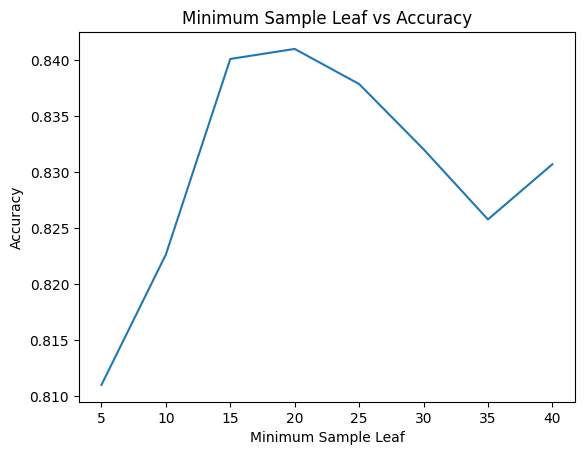

In [67]:
#Plot to see which level is best
plt.plot(min_leaf_options,results_min_leaf)
plt.title("Minimum Sample Leaf vs Accuracy")
plt.xlabel("Minimum Sample Leaf")
plt.ylabel("Accuracy")
plt.show()

Minimum sample leaf should be 20.

In [68]:
# Maximum Feature
results_max_feat = []
recall = []
precision = []
f1 = []
max_feat_options = ["auto",None,0.3,0.4,0.5,0.6,0.7,0.8]
for trees in max_feat_options:
  model = DecisionTreeClassifier(max_features=trees, random_state = 42)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accuracy = np.mean(y_test==y_pred)
  results_max_feat.append(accuracy)
  recall.append(recall_score(y_test,y_pred, average = 'weighted'))
  precision.append(precision_score(y_test,y_pred, average = 'weighted'))
  f1.append(f1_score(y_test,y_pred, average = 'weighted'))

table3 = pd.DataFrame({"Maximum Feature":max_feat_options,
                      "Accuracy":results_max_feat,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table3

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


Maximum Feature  Accuracy    Recall  Precision  F1 Score
0            auto  0.774295  0.774295   0.774199  0.774232
1            None  0.797134  0.797134   0.797124  0.797129
2             0.3  0.797134  0.797134   0.797124  0.797129
3             0.4  0.805643  0.805643   0.805591  0.805611
4             0.5  0.793103  0.793103   0.793126  0.793114
5             0.6  0.793551  0.793551   0.793452  0.793475
6             0.7  0.799821  0.799821   0.799766  0.799573
7             0.8  0.796238  0.796238   0.796249  0.796243

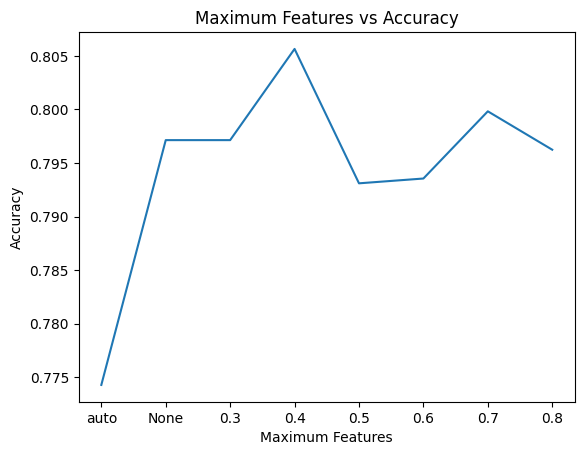

In [69]:
plt.plot(["auto","None",0.3,0.4,0.5,0.6,0.7,0.8],results_max_feat)
plt.title("Maximum Features vs Accuracy")
plt.xlabel("Maximum Features")
plt.ylabel("Accuracy")
plt.show()

Max Features = 0.4

In [70]:
# Maximum Depth
results_max_dep = []
recall = []
precision = []
f1 = []
max_depth_options = [2,4,6,8,10,12,14,16,18,20]
for trees in max_depth_options:
  model = DecisionTreeClassifier(max_depth = trees, random_state = 42)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  accuracy = np.mean(y_test==y_pred)
  results_max_dep.append(accuracy)
  recall.append(recall_score(y_test,y_pred, average = 'weighted'))
  precision.append(precision_score(y_test,y_pred, average = 'weighted'))
  f1.append(f1_score(y_test,y_pred, average = 'weighted'))

table4 = pd.DataFrame({"Maximum Depth":max_depth_options,
                      "Accuracy":results_max_dep,
                      "Recall":recall,
                      "Precision":precision,
                      "F1 Score": f1})
table4

Maximum Depth  Accuracy    Recall  Precision  F1 Score
0              2  0.767129  0.767129   0.768898  0.765681
1              4  0.782356  0.782356   0.786521  0.780303
2              6  0.816391  0.816391   0.819762  0.816502
3              8  0.827586  0.827586   0.828456  0.827714
4             10  0.827138  0.827138   0.827315  0.827194
5             12  0.826243  0.826243   0.826454  0.826306
6             14  0.824004  0.824004   0.823931  0.823880
7             16  0.817286  0.817286   0.817268  0.817277
8             18  0.810121  0.810121   0.810058  0.810079
9             20  0.807882  0.807882   0.807788  0.807798

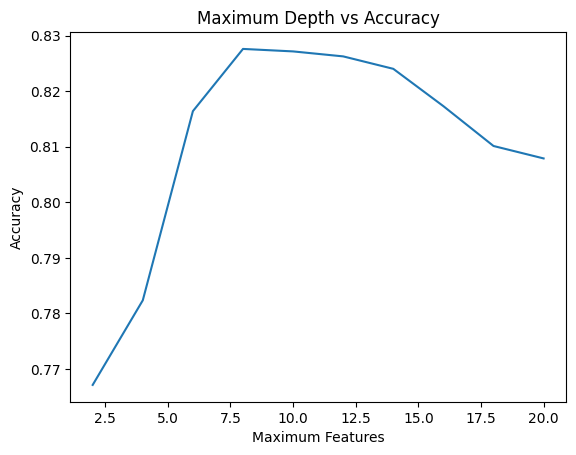

In [71]:
# Plot to see which level is best
plt.plot(max_depth_options,results_max_dep)
plt.title("Maximum Depth vs Accuracy")
plt.xlabel("Maximum Features")
plt.ylabel("Accuracy")
plt.show()

Maximum Depth = 7.5

## Creation of Tuned Tree

The best hyper-parameter values were as follows:


1.   Split Criteria: Entropy
2.   Minimum Sample Leaf: 20
3.   Maximum Feature: 0.4
4.   Maximum Depth: 8

In [72]:
# Create tree with hyper-parameters above:
dtree = DecisionTreeClassifier(max_depth = 8, random_state = 101,
                               max_features = 0.4, min_samples_leaf= 20, criterion = 'entropy')
dtree.fit(X_train,y_train)
y_pred = dtree.predict(X_test)

In [73]:
# Confusion Matrix
data_cm = confusion_matrix(y_test, y_pred)
print(data_cm)

[[883 298]
 [142 910]]


In [74]:
# Accuracy Score
print(accuracy_score(y_test,y_pred))

0.8029556650246306


In [75]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80      1181
           1       0.75      0.87      0.81      1052

    accuracy                           0.80      2233
   macro avg       0.81      0.81      0.80      2233
weighted avg       0.81      0.80      0.80      2233



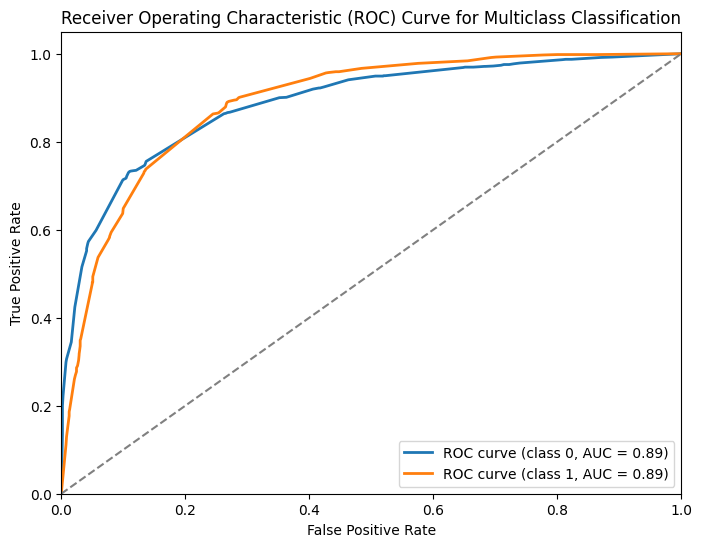

In [76]:
# Calculate ROC curve and AUC score for each class
n_classes = len(dtree.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    y_test_binary = (y_test == i)  # Create binary target for the current class
    y_prob_class = dtree.predict_proba(X_test)[:, i]  # Predict probabilities for the current class
    fpr[i], tpr[i], _ = roc_curve(y_test_binary, y_prob_class)
    roc_auc[i] = roc_auc_score(y_test_binary, y_prob_class)

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d, AUC = %0.2f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc='lower right')
plt.show()

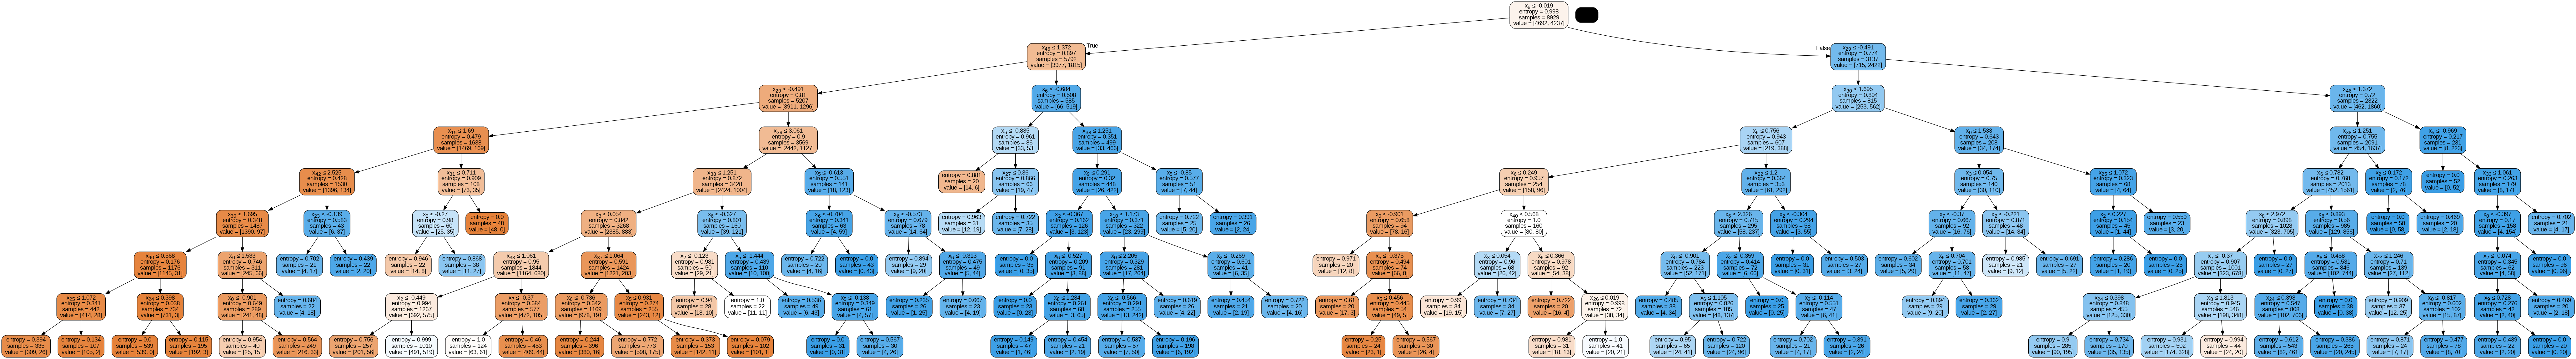

In [77]:
# Graph the decision tree
graph_data = StringIO()
export_graphviz(dtree, out_file= graph_data,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(graph_data.getvalue())
Image(graph.create_png())

In [78]:
feature_names = X.columns.tolist()

# Find the features used in the final decision tree
# Get the indices of features used in splits
used_feature_indices = dtree.tree_.feature

# Get the names of features used in splits and remove duplicates
used_feature_names = set([feature_names[i] for i in used_feature_indices if i != -2])

# Convert set of unique feature names to a list
unique_feature_names_list = list(used_feature_names)

print("Unique features used by the tuned decision tree (dtree):")
for feature in unique_feature_names_list:
    print(feature)
print("Count of unique features used by the tuned decision tree (dtree):", len(unique_feature_names_list))

Unique features used by the tuned decision tree (dtree):
month_jun
education_secondary
balance
month_oct
housing
education_tertiary
age
marital_single
month_mar
job_retired
contact_cellular
previous
contact_unknown
pdays
month_jul
duration
month_aug
poutcome_failure
month_may
marital_married
marital_divorced
poutcome_success
job_admin.
campaign
education_primary
contact_telephone
day
Count of unique features used by the tuned decision tree (dtree): 27


## Model #2 Creation - Logistic Regression Model

We are also going to create a logistic regression model. This model will classify the target variable, 'deposit' into either 'yes' or 'no' based on the customer's profile and the factors from the above table.

In [79]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=101)

In [80]:
# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Display the summary of the model
print(result.summary())

         Current function value: 0.411994
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                 8929
Model:                          Logit   Df Residuals:                     8887
Method:                           MLE   Df Model:                           41
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.4045
Time:                        12:56:37   Log-Likelihood:                -3678.7
converged:                      False   LL-Null:                       -6177.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                    -0.0177      0.042     -0.418      0.676      -0.101       0.065
default                -0.0054      0.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


We most likely run into this NaN issue because of perfect multicolinearity between some fo the one-hot encoded variables. Let's remove one of the variables from each category to fix that.

In [81]:
X_train.drop(['job_unknown','marital_divorced', 'education_unknown', 'contact_telephone', 'month_apr','poutcome_other'], axis = 1, inplace = True)
X_test.drop(['job_unknown','marital_divorced', 'education_unknown', 'contact_telephone', 'month_apr','poutcome_other'], axis = 1, inplace = True)

In [82]:
# Let's try again
# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Display the summary of the model
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.411994
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                 8929
Model:                          Logit   Df Residuals:                     8887
Method:                           MLE   Df Model:                           41
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.4045
Time:                        12:56:37   Log-Likelihood:                -3678.7
converged:                       True   LL-Null:                       -6177.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
age                    -0.0177      0.042     -0.418      0.676      -0.101       0.065
de

Great, this looks much better. Now let's take a look at some more summary statistics, against the test dataset.

Accuracy: 0.8302731751007613
Recall: 0.7946768060836502
Precision: 0.8368368368368369
F1 Score: 0.8152120916626036


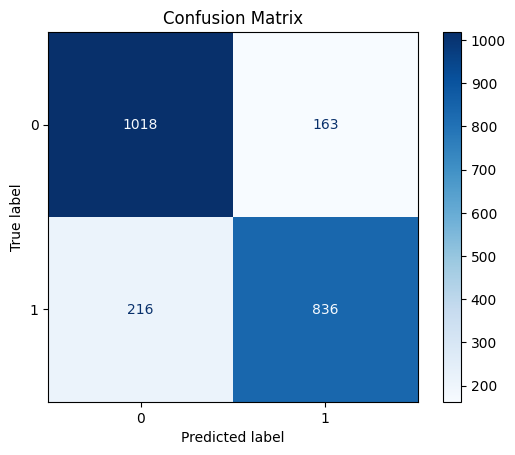

In [83]:
# Predict on the test set
y_pred = result.predict(X_test)
y_pred_class = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Feature Selection for Logistic Regression

We are going to use a backwards stepwise function to reduce the size of the model. The more complex a model, the less you can take away from it in terms of what is actually having an effect on our classifier.

So, we use reduce the model by stepping it down in size based on significance level. We are going to remove the features that have a significance level above p=0.05 and rerun the model until all of the features are significant.

In [84]:
def backward_stepwise_selection(X_train, y_train, significance_level=0.05):
    while True:
        # Fit the model
        logit_model = sm.Logit(y_train, X_train).fit(disp=0)
        p_values = logit_model.pvalues

        # Find the feature with the highest p-value
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            # Remove the feature with the highest p-value
            excluded_feature = p_values.idxmax()
            X_train = X_train.drop(columns=[excluded_feature])
        else:
            break

    return logit_model, X_train.columns.tolist()

# Perform backward stepwise selection
final_model, selected_features = backward_stepwise_selection(X_train, y_train)

# Display the summary of the final model
print(final_model.summary())
print("Selected features:", selected_features)


                           Logit Regression Results                           
Dep. Variable:                deposit   No. Observations:                 8929
Model:                          Logit   Df Residuals:                     8905
Method:                           MLE   Df Model:                           23
Date:                Sun, 23 Jun 2024   Pseudo R-squ.:                  0.4031
Time:                        12:56:41   Log-Likelihood:                -3687.6
converged:                       True   LL-Null:                       -6177.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
balance                0.0670      0.030      2.250      0.024       0.009       0.125
housing               -0.3518      0.034    -10.410      0.000      -0.418      -0.286
loan                

Evaluation on Test Data with Reduced Model:
Accuracy: 0.8325123152709359
Recall: 0.7965779467680608
Precision: 0.8396793587174348
F1 Score: 0.817560975609756


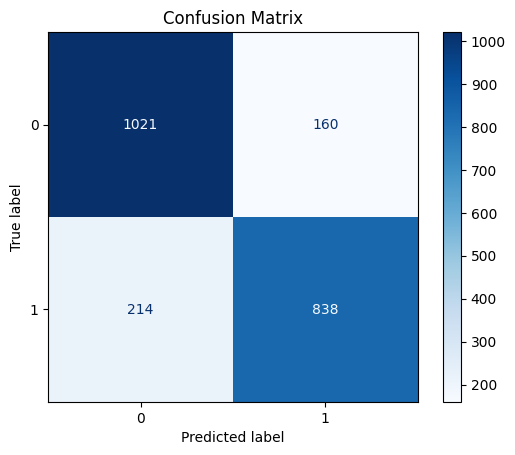

In [85]:
# Predict on the test set using the reduced model
X_test_reduced = X_test[selected_features]
y_pred = final_model.predict(X_test_reduced)
y_pred_class = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)

print("Evaluation on Test Data with Reduced Model:")
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


By reducing the size of the model to get rid of insignificant features, we actually increased the accuracy of the model from about 83.0% to 83.2%. This is not much, but we reduced the number of features in the model from 42 to 24. This allows us to be more precise in determining which variables are actually having an effect on the model.

Because we scaled our variables, we can look at the coefficients of each term in the regression to see the impact that each variable has. Not surprisingly, the feature with the largest coefficient is the duration of the call. It is the the only coefficient larger than 0.70, and is at 1.89! As stated in the EDA analysis, making sure the calls last are super important!

The other EDA analyses are also prevalent in the regression model, including housing loan status, number of calls, balance all have higher impacts on the regression model than most variables.

And interesting one that was not mentioned in the EDA that is seen here is that those who made deposits in the past marketing campaigns are inclined to do so again. Reach out to these people again!